<h1> Data Exploration & Merging

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import textwrap

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


<h2> Application_Data Exploratory Data Analysis (EDA)

In [2]:
df = pd.read_csv('ApplicationData.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 120 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(63), int64(41), object(16)
memory usage: 281.5+ MB


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


<h4> Function To Plot KDE

In [3]:
def plot_histogram(df, column, bins=50):
    plt.figure(figsize=(7, 5))
    sns.histplot(df[column].dropna(), bins=bins, kde=False)
    plt.title(f"Histogram of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
    
def plot_kde_by_target(df, column, target_col='TARGET'):
    plt.figure(figsize=(7, 5))
    for value in sorted(df[target_col].dropna().unique()):
        sns.kdeplot(
            df[df[target_col] == value][column].dropna(),
            label=f"{target_col} = {value}",
            shade=True
        )
    plt.title(f"KDE of {column} by {target_col}")
    plt.xlabel(column)
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_horizontal_categorical_bar(df, column, top_n=None, rotate_labels=False):
    """
    - top_n: if set, only plots the top N most frequent categories
    """
    value_counts = df[column].value_counts(dropna=False)

    if top_n:
        value_counts = value_counts.head(top_n)
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=value_counts.values, y=value_counts.index, orient='h')
    plt.title(f"Distribution of '{column}'")
    plt.xlabel("Count")
    plt.ylabel(column)
    if rotate_labels:
        plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
num_columns_to_plot = [
    'AMT_CREDIT',
    'AMT_ANNUITY',
    'DAYS_BIRTH',
    'EXT_SOURCE_1',
    'FLOORSMAX_AVG'
]

# Histograms (univariate)
for col in num_columns_to_plot:
    if col in df.columns:
        plot_histogram(df, col)
        plot_kde_by_target(df, col, target_col='TARGET')

In [ ]:
cat_columns_to_plot = [
    'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE'
]

# Histograms (univariate)
for col in cat_columns_to_plot:
    if col in df.columns:
        plot_horizontal_categorical_bar(df, col, top_n=10)
    

Note: The empty looking bar charts are not actually empty. Eg There are 10 students under NAME_INCOME_TYPE

<h3> Checking for % Missing Values

In [ ]:
missing = df.isnull().mean().sort_values(ascending=False)
missing = missing[missing > 0] * 100  # Show as percentage

pd.set_option('display.max_rows', None)
display(missing.reset_index().rename(columns={'index': 'Column', 0: 'Missing (%)'}))

<h2> Flattening Bureau Data & Bureau Data EDA

In [ ]:
bureau_df = pd.read_csv("BureauData.csv")
# Using domain logic to drop columns not useful for aggregation
bureau_df.info()
bureau_df.head()

In [ ]:
missing = bureau_df.isnull().mean().sort_values(ascending=False)
missing = missing[missing > 0] * 100  # Show as percentage

pd.set_option('display.max_rows', None)
display(missing.reset_index().rename(columns={'index': 'Column', 0: 'Missing (%)'}))

<h3>Univariate Analysis

In [26]:
# Separating columns by type for visualisation
continuous_columns = [
    "DAYS_CREDIT",
    "CREDIT_DAY_OVERDUE",
    "DAYS_CREDIT_ENDDATE",
    "DAYS_ENDDATE_FACT",
    "AMT_CREDIT_MAX_OVERDUE",
    "CNT_CREDIT_PROLONG",
    "AMT_CREDIT_SUM",
    "AMT_CREDIT_SUM_DEBT",
    "AMT_CREDIT_SUM_LIMIT",
    "AMT_CREDIT_SUM_OVERDUE",
    "DAYS_CREDIT_UPDATE",
    "AMT_ANNUITY"
]

categorical_columns = [
    "CREDIT_ACTIVE",
    "CREDIT_CURRENCY",
    "CREDIT_TYPE"
]

Continuous Features (with log transform & outlier clipping)

In [ ]:
# Set up subplots
num_rows = (len(continuous_columns) + 2) // 3
num_cols = min(len(continuous_columns), 3)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 4 * num_rows))
axes = axes.flatten()

# Plot each histogram
for i, column in enumerate(continuous_columns):
    data = bureau_df[column].dropna()
    data = data[data > 0]  # log1p requires > 0
    if not data.empty:
        data_log = np.log1p(data)
        q_low = data_log.quantile(0.01)
        q_high = data_log.quantile(0.99)
        data_clipped = data_log[(data_log >= q_low) & (data_log <= q_high)]
        data_clipped.hist(ax=axes[i], bins=30)
        axes[i].set_title(f"log1p({column}) (1–99% clipped)")
        axes[i].set_xlabel("Value")
        axes[i].set_ylabel("Frequency")
    else:
        axes[i].set_visible(False)  # skip empty plots

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Categorical Features

In [ ]:
for col in categorical_columns:
    if col in bureau_df.columns:
        plot_horizontal_categorical_bar(bureau_df, col)

<h4> Dropping Columns based on EDA

In [5]:
bureau_df = bureau_df.drop(columns=[
    "SK_ID_BUREAU",        # Only identifies individual credit records
    "CREDIT_CURRENCY",     # 99.9% = currency 1
    "DAYS_CREDIT_UPDATE"   # Too redundant with DAYS_CREDIT / END_DATE
])

<h4> Grouping & Aggregation

In [6]:
# Step 2: Aggregation
agg_map = {
    "DAYS_CREDIT": "min",
    "DAYS_CREDIT_ENDDATE": "mean",
    "CREDIT_DAY_OVERDUE": "max",
    "AMT_CREDIT_MAX_OVERDUE": "max",
    "AMT_CREDIT_SUM_OVERDUE": "sum",
    "AMT_CREDIT_SUM": ["sum", "mean"],
    "AMT_CREDIT_SUM_DEBT": ["sum", "mean"],
    "CNT_CREDIT_PROLONG": "sum"
}

bureau_agg = bureau_df.groupby("SK_ID_CURR").agg(agg_map)
bureau_agg.columns = ['_'.join(col).strip('_') for col in bureau_agg.columns]
bureau_agg = bureau_agg.reset_index()

# Step 3: Pivot CREDIT_ACTIVE counts
status_counts = (
    bureau_df.pivot_table(index="SK_ID_CURR", columns="CREDIT_ACTIVE", values="AMT_CREDIT_SUM", aggfunc="count", fill_value=0)
    .reset_index()
)
status_counts.columns = ["SK_ID_CURR"] + [f"CREDIT_ACTIVE_{c}" for c in status_counts.columns[1:]]
# Step 4: Merge everything
bureau_flat = bureau_agg.merge(status_counts, on="SK_ID_CURR", how="left")

<h4> Merging </h4>

In [7]:
#Merge Datasets on SK_ID_CURR
merged_data = df.merge(bureau_flat, on="SK_ID_CURR", how="left")
merged_data.drop(columns="SK_ID_CURR",inplace=True)
#Save the Final Merged Data to CSV
merged_data.to_csv("after_merge.csv", index=False)
#Preview Merged Data
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 133 entries, TARGET to CREDIT_ACTIVE_Sold
dtypes: float64(77), int64(40), object(16)
memory usage: 312.0+ MB


<h1> Data Preparation

<h3>Data Selection. <b>This time, we are not Dropping Or Aggregating Any Columns Before IV values are found </b>  </h3>
<h4>House Improvement Loans : 
<br>1 Only for thow who own a house <br>
2 Age must be above 21 and less than 65 years (including leap years)


In [78]:
df = pd.read_csv('after_merge.csv')
df = df[
    (df['FLAG_OWN_REALTY'] == 'Y') &
    (df['DAYS_BIRTH'] < -7670) &
    (df['DAYS_BIRTH'] > -23741)
]

<h1> Grouping And Screening

<h3> Fine Classing

In [79]:
#convert to categorical
cols_to_object = [
    'NAME_CONTRACT_TYPE',
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    'NAME_INCOME_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS',
    'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE',
    'ORGANIZATION_TYPE',
    'FLAG_EMP_PHONE',         # binary (0/1)
    'FLAG_WORK_PHONE',        # binary
    'FLAG_CONT_MOBILE',       # binary
    'FLAG_EMAIL',             # binary
    'REG_REGION_NOT_WORK_REGION',  # binary
    'REG_CITY_NOT_LIVE_CITY',      # binary
    'REG_CITY_NOT_WORK_CITY',      # binary
]
for col in cols_to_object:
    if col in df.columns:
        df[col] = df[col].astype(str).astype('object')

for col in df.columns:
    if col not in cols_to_object:
        df[col] = pd.to_numeric(df[col], errors='coerce')


df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 207300 entries, 0 to 307509
Columns: 133 entries, TARGET to CREDIT_ACTIVE_Sold
dtypes: float64(84), int64(33), object(16)
memory usage: 211.9+ MB


In [80]:
def calculate_iv_all(df, target_col='TARGET', bins=20): 
    iv_summary = []

    # Separate numerical and categorical columns
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include='object').columns.tolist()

    # Remove target column from both lists
    numerical_cols = [col for col in numerical_cols if col != target_col]
    categorical_cols = [col for col in categorical_cols if col != target_col]

    # --- Numerical Features ---
    for col in numerical_cols:
        temp_df = df[[col, target_col]].copy()

        try:
            # Ensure column has enough unique values for binning
            non_null = temp_df[col].dropna()
            if non_null.nunique() < 2:
                print(f"Skipping {col} (less than or equal to 2 unique non-null values)")
                continue

            # Bin using qcut
            temp_df['Bin_Range'] = pd.qcut(non_null, q=bins, duplicates='drop')
            temp_df = temp_df.loc[temp_df['Bin_Range'].notna()]  # Remove any rows without bin

            # Add back missing rows as 'Missing'
            temp_df['Bin_Range'] = temp_df['Bin_Range'].astype(object)
            missing_mask = temp_df[col].isna()
            temp_df.loc[missing_mask, 'Bin_Range'] = 'Missing'

            iv_summary.append({
                'Variable': col,
                'IV': _calculate_iv(temp_df, target_col)
            })

        except (ValueError, IndexError) as e:
            print(f"Skipping {col} due to error: {e}")
            continue

    # --- Categorical Features ---
    for col in categorical_cols:
        temp_df = df[[col, target_col]].copy()
        temp_df['Bin_Range'] = temp_df[col].astype(str).fillna('Missing')

        iv_summary.append({
            'Variable': col,
            'IV': _calculate_iv(temp_df, target_col)
        })

    # Return as sorted DataFrame
    iv_df = pd.DataFrame(iv_summary).sort_values(by='IV', ascending=False)
    return iv_df



def _calculate_iv(temp_df, target_col):
    grouped = temp_df.groupby('Bin_Range')
    total_events = temp_df[target_col].sum()
    total_non_events = len(temp_df) - total_events

    iv_table = grouped.agg({target_col: ['count', 'sum']}).reset_index()
    iv_table.columns = ['Bin_Range', 'Count', 'Events']
    iv_table['Non_Events'] = iv_table['Count'] - iv_table['Events']
    iv_table['%_Events'] = iv_table['Events'] / total_events
    iv_table['%_Non_Events'] = iv_table['Non_Events'] / total_non_events

    # Avoid division by 0
    iv_table['WOE'] = np.log((iv_table['%_Non_Events'] + 1e-6) / (iv_table['%_Events'] + 1e-6))
    iv_table['IV'] = (iv_table['%_Non_Events'] - iv_table['%_Events']) * iv_table['WOE']

    return iv_table['IV'].sum()

In [81]:
iv_df = calculate_iv_all(df, target_col='TARGET', bins=20)
iv_df.head(20)

Skipping CODE_GENDER (less than or equal to 2 unique non-null values)
Skipping NAME_TYPE_SUITE (less than or equal to 2 unique non-null values)
Skipping WEEKDAY_APPR_PROCESS_START (less than or equal to 2 unique non-null values)
Skipping FONDKAPREMONT_MODE (less than or equal to 2 unique non-null values)
Skipping HOUSETYPE_MODE (less than or equal to 2 unique non-null values)
Skipping WALLSMATERIAL_MODE (less than or equal to 2 unique non-null values)
Skipping EMERGENCYSTATE_MODE (less than or equal to 2 unique non-null values)


,Variable,IV
20,EXT_SOURCE_1,0.361608
4,AMT_GOODS_PRICE,0.108008
7,DAYS_EMPLOYED,0.104728
120,OCCUPATION_TYPE,0.080222
95,DAYS_CREDIT_min,0.080147
6,DAYS_BIRTH,0.079927
96,DAYS_CREDIT_ENDDATE_mean,0.076357
124,ORGANIZATION_TYPE,0.068933
103,AMT_CREDIT_SUM_DEBT_mean,0.055783
10,OWN_CAR_AGE,0.053697


<h3> Characteristic Screening

In [82]:
important_vars = [
    'EXT_SOURCE_1',
    'AMT_GOODS_PRICE',
    'DAYS_EMPLOYED',
    'OCCUPATION_TYPE',
    'DAYS_CREDIT_min',
    'DAYS_BIRTH',
    'DAYS_CREDIT_ENDDATE_mean',
    'ORGANIZATION_TYPE',
    'AMT_CREDIT_SUM_DEBT_mean',
    'OWN_CAR_AGE',
    'NAME_INCOME_TYPE',
    'TARGET'
]

df.drop(columns=[col for col in df.columns if col not in important_vars], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 207300 entries, 0 to 307509
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   TARGET                    207300 non-null  int64  
 1   AMT_GOODS_PRICE           207077 non-null  float64
 2   NAME_INCOME_TYPE          207300 non-null  object 
 3   DAYS_BIRTH                207300 non-null  int64  
 4   DAYS_EMPLOYED             207300 non-null  int64  
 5   OWN_CAR_AGE               71520 non-null   float64
 6   OCCUPATION_TYPE           207300 non-null  object 
 7   ORGANIZATION_TYPE         207300 non-null  object 
 8   EXT_SOURCE_1              89268 non-null   float64
 9   DAYS_CREDIT_min           176852 non-null  float64
 10  DAYS_CREDIT_ENDDATE_mean  175373 non-null  float64
 11  AMT_CREDIT_SUM_DEBT_mean  172010 non-null  float64
dtypes: float64(6), int64(3), object(3)
memory usage: 20.6+ MB


<h3>Functions for Coarse Classing (Manual Binning)

In [83]:
def woe_iv(data, variable_name):
    working_data = data.copy()
    working_data['Bin_Range'] = working_data['Bin_Range'].astype(str).fillna('Missing')

    variable_data = pd.DataFrame()
    variable_data['Bin_Range'] = working_data.groupby('Bin_Range', as_index=False).count()['Bin_Range']
    variable_data['Count'] = working_data.groupby('Bin_Range')['TARGET'].count().values
    variable_data['Events'] = working_data.groupby('Bin_Range')['TARGET'].sum().values
    variable_data['Non_Events'] = variable_data['Count'] - variable_data['Events']

    variable_data['%_of_Events'] = variable_data['Events'] / sum(variable_data['Events'])
    variable_data['%_of_Non_Events'] = variable_data['Non_Events'] / sum(variable_data['Non_Events'])

    variable_data['WOE'] = np.log((variable_data['%_of_Non_Events'] + 1e-6) / (variable_data['%_of_Events'] + 1e-6))
    variable_data['IV'] = (variable_data['%_of_Non_Events'] - variable_data['%_of_Events']) * variable_data['WOE']

    IV = variable_data['IV'].sum()
    return IV, variable_data

In [84]:
def woe_iv_plot(data, variable_name):
    IV, variable_data = woe_iv(data, variable_name)
    print(f"IV for {variable_name} with {variable_data.shape[0]} bins: {round(IV, 4)}")

    fig_width = max(20, len(variable_data['Bin_Range']) * 0.6)
    fig, ax1 = plt.subplots(figsize=(fig_width, 6))
    variable_data = variable_data.copy()
    variable_data['Bin_Range'] = variable_data['Bin_Range'].astype(str)

    # Plot WOE line
    sns.lineplot(data=variable_data, x='Bin_Range', y='WOE', marker='o', ax=ax1, label='WOE', color='black')
    for i, row in variable_data.iterrows():
        ax1.text(i, row['WOE'], f"{row['WOE']:.2f}", ha='center', va='bottom', fontsize=10, color='black')
    ax1.set_ylabel("WOE", fontsize=12)
    ax1.tick_params(axis='x', rotation=45)

    # Plot stacked bar for good and bad percentages
    ax2 = ax1.twinx()
    width = 0.5
    r = np.arange(len(variable_data))
    ax2.bar(r, variable_data['%_of_Events'], width=width, label='% Good', color='green', alpha=0.3)
    ax2.bar(r, variable_data['%_of_Non_Events'], width=width, bottom=variable_data['%_of_Events'], label='% Bad', color='red', alpha=0.6)
    ax2.set_ylabel("Proportion of Records", fontsize=12)
    ax2.set_xticks(r)
    ax2.set_xticklabels(variable_data['Bin_Range'], rotation=45)

    ax2.legend(loc='upper right')
    plt.title(f"WOE Plot for {variable_name}")
    plt.tight_layout()
    plt.show()

In [85]:
def plot_numeric_woe(df, variable, bins):
    df[variable] = pd.to_numeric(df[variable], errors='coerce')
    woe_bin_data = df[[variable, "TARGET"]].copy()
    woe_bin_data['Bin_Range'] = pd.qcut(woe_bin_data[variable], q=bins, duplicates='drop')
    woe_bin_data['Bin_Range'] = woe_bin_data['Bin_Range'].astype(str).fillna('Missing')
    woe_iv_plot(woe_bin_data, variable)
    
def plot_numeric_woe_manual(df, variable, bin_edges):
    df = df[[variable, 'TARGET']].copy()
    df[variable] = pd.to_numeric(df[variable], errors='coerce')
    df['Bin_Range'] = pd.cut(df[variable], bins=bin_edges, include_lowest=True)
    df['Bin_Range'] = df['Bin_Range'].astype(str).fillna('Missing')

    IV, variable_data = woe_iv(df, variable)
    variable_data = variable_data.sort_values(by='WOE').reset_index(drop=True)

    print(f"\nIV for {variable} with {variable_data.shape[0]} bins: {round(IV, 4)}")
    print("WOE values per Bin_Range:")
    for _, row in variable_data.iterrows():
        print(f"  {row['Bin_Range']}: WOE = {row['WOE']:.6f}")
    
    woe_iv_plot(df, variable)

In [98]:
def woe_iv_plot_categorical(df, variable_name, target_name='TARGET'):
    """
    Plots WOE values for a categorical variable, with % good and bad bars stacked.
    Also displays IV on the plot.
    """
    working_data = df[[variable_name, target_name]].copy()
    working_data[variable_name] = working_data[variable_name].fillna('Missing')
    working_data['Bin_Range'] = working_data[variable_name].astype(str)

    IV, variable_data = woe_iv(working_data, variable_name)
    variable_data = variable_data.sort_values(by='WOE', ascending=True).reset_index(drop=True)

    fig_width = max(20, len(variable_data['Bin_Range']) * 0.6)
    fig, ax1 = plt.subplots(figsize=(fig_width, 6))

    r = range(len(variable_data))
    width = 0.5
    ax2 = ax1.twinx()
    ax2.bar(r, variable_data['%_of_Events'], width=width, label='% Good', color='green', alpha=0.3)
    ax2.bar(r, variable_data['%_of_Non_Events'], bottom=variable_data['%_of_Events'],
            width=width, label='% Bad', color='red', alpha=0.3)
    ax2.set_ylabel("Event Distribution", fontsize=12)
    ax2.set_xticks(r)
    ax2.set_xticklabels(variable_data['Bin_Range'], rotation=45, ha='right', fontsize=10)
    ax2.tick_params(axis='x', labelsize=10)

    sns.lineplot(x=r, y=variable_data['WOE'], marker='o', ax=ax1, color='black', label='WOE')
    ax1.set_ylabel("WOE", fontsize=12)

    # Display IV in plot title
    plt.title(f"WOE Plot for {variable_name}\nInformation Value (IV) = {IV:.6f}", fontsize=14)
    fig.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    
def woe_iv_plot_categorical_manual(df, variable_name, cut_indices, target_name='TARGET'):
    """
    Manually groups categories based on cut indices, plots WOE, and prints IV before/after and WOE values per grouped bin.
    """
    working_data = df[[variable_name, target_name]].copy()
    working_data[variable_name] = working_data[variable_name].fillna('Missing')
    working_data['Bin_Range'] = working_data[variable_name].astype(str)

    # Step 1: Original WOE and IV (before binning)
    IV_before, variable_data_before = woe_iv(working_data, variable_name)
    sorted_categories = variable_data_before.sort_values('WOE')['Bin_Range'].tolist()

    # Step 2: Group categories based on cut_indices
    grouped_mapping = {}
    group_labels = []
    raw_group_labels = []  # For printing purposes

    for i in range(len(cut_indices) - 1):
        group = sorted_categories[cut_indices[i]:cut_indices[i + 1]]
        raw_label = ', '.join(group)
        label_wrapped = textwrap.fill(raw_label, width=30)
        group_labels.append(label_wrapped)
        raw_group_labels.append(raw_label)
        for cat in group:
            grouped_mapping[cat] = label_wrapped

    # Step 3: Apply grouped binning
    working_data['Bin_Range'] = working_data['Bin_Range'].map(grouped_mapping).fillna(working_data['Bin_Range'])

    # Step 4: Recalculate WOE and IV (after binning)
    IV_after, variable_data_grouped = woe_iv(working_data, variable_name)
    variable_data_grouped = variable_data_grouped.sort_values(by='WOE').reset_index(drop=True)

    # Step 5: Plot
    fig_width = max(22, len(variable_data_grouped['Bin_Range']) * 0.9)
    fig, ax1 = plt.subplots(figsize=(fig_width, 6))
    r = range(len(variable_data_grouped))
    width = 0.5

    ax2 = ax1.twinx()
    ax2.bar(r, variable_data_grouped['%_of_Events'], width=width, label='% Good', color='green', alpha=0.3)
    ax2.bar(r, variable_data_grouped['%_of_Non_Events'], bottom=variable_data_grouped['%_of_Events'],
            width=width, label='% Bad', color='red', alpha=0.3)
    ax2.set_ylabel("Event Distribution", fontsize=12)
    ax2.set_xticks(r)
    ax2.set_xticklabels(variable_data_grouped['Bin_Range'], rotation=30, ha='right', fontsize=9)

    sns.lineplot(x=r, y=variable_data_grouped['WOE'], marker='o', ax=ax1, color='black', label='WOE')
    for i, row in variable_data_grouped.iterrows():
        ax1.text(i, row['WOE'], f"{row['WOE']:.6f}", ha='center', va='bottom', fontsize=9, color='black')

    ax1.set_ylabel("WOE", fontsize=12)
    plt.title(
        f"WOE Plot (Grouped) for {variable_name}\nIV Before Binning = {IV_before:.6f} | IV After Binning = {IV_after:.6f}",
        fontsize=13
    )
    fig.legend(loc='upper right')
    plt.tight_layout(pad=2)
    plt.show()

    # Step 6: Print summary
    print(f"\nInformation Value (IV) Before Binning: {IV_before:.6f}")
    print(f"Information Value (IV) After Binning:  {IV_after:.6f}")
    print("\nWOE for each grouped bin:")
    for i, row in variable_data_grouped.iterrows():
        print(f"Group {i + 1}:")
        print(f"  Categories: {raw_group_labels[i]}")
        print(f"  WOE: {row['WOE']:.6f}\n")

<h2> Coarse Classing

IV for EXT_SOURCE_1 with 21 bins: 0.156


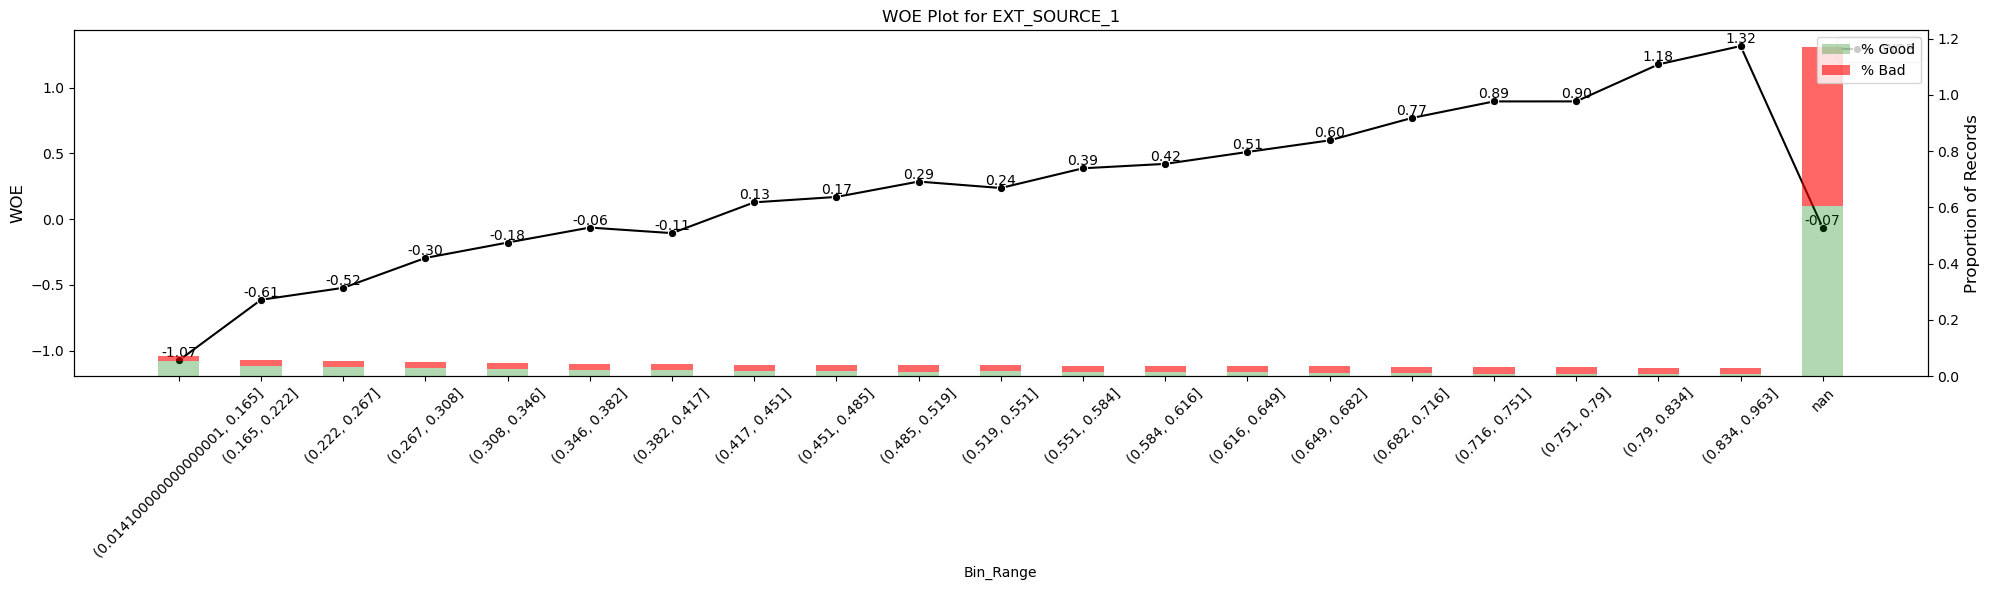


IV for EXT_SOURCE_1 with 6 bins: 0.1455
WOE values per Bin_Range:
  (-0.001, 0.2]: WOE = -0.944086
  (0.2, 0.4]: WOE = -0.286087
  nan: WOE = -0.066502
  (0.4, 0.6]: WOE = 0.220192
  (0.6, 0.8]: WOE = 0.715789
  (0.8, 1.0]: WOE = 1.255695
IV for EXT_SOURCE_1 with 6 bins: 0.1455


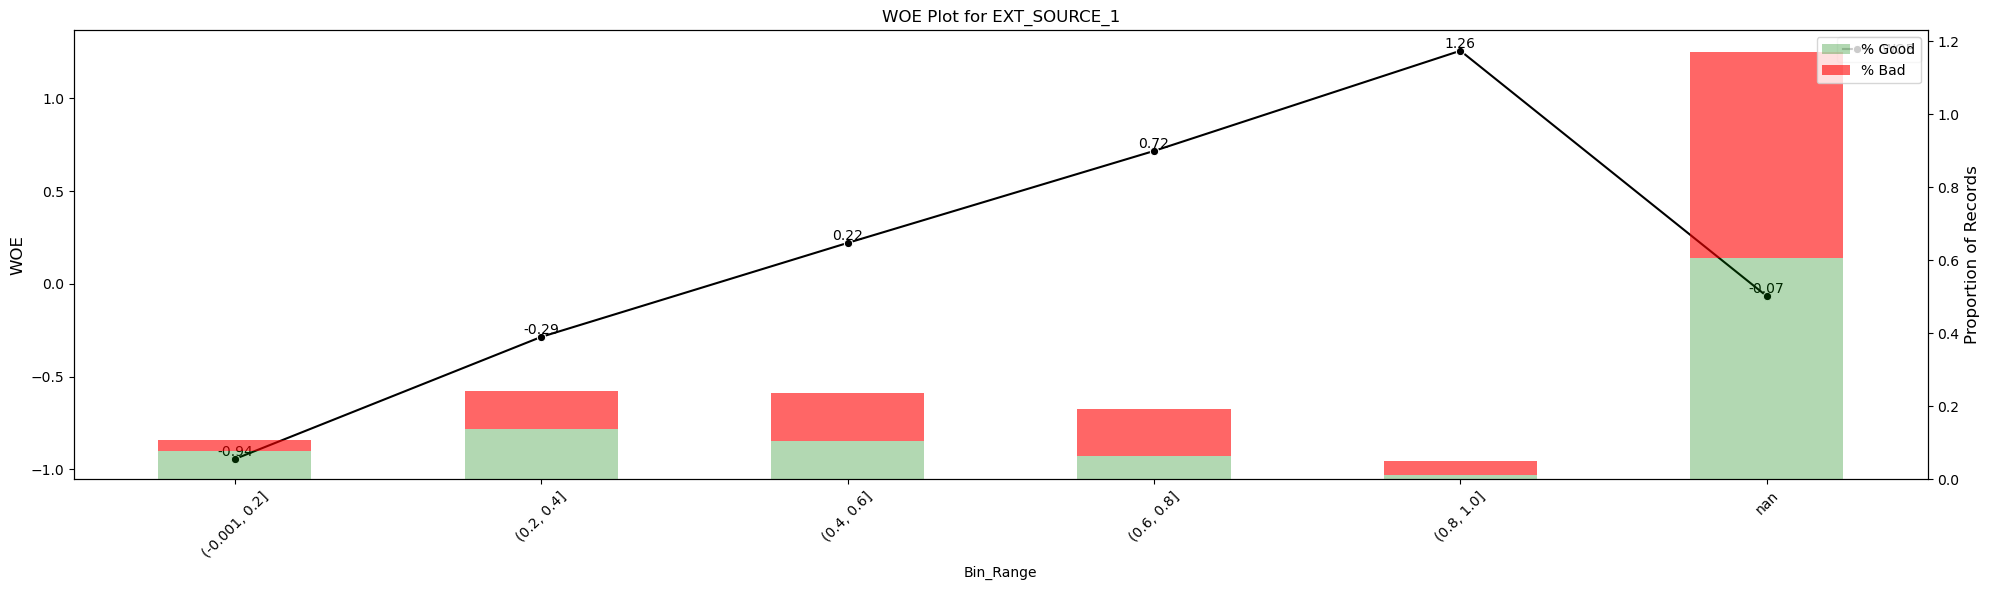

In [87]:
df["TARGET"] = pd.to_numeric(df["TARGET"], errors='coerce')
plot_numeric_woe(df, 'EXT_SOURCE_1', 20)
plot_numeric_woe_manual(df, 'EXT_SOURCE_1', [0,0.2, 0.4, 0.6,0.8,1])

Difficult to coarse class AMT_GOODS_PRICE, IV drops too much in trying to make it monatonic

IV for AMT_GOODS_PRICE with 20 bins: 0.1079


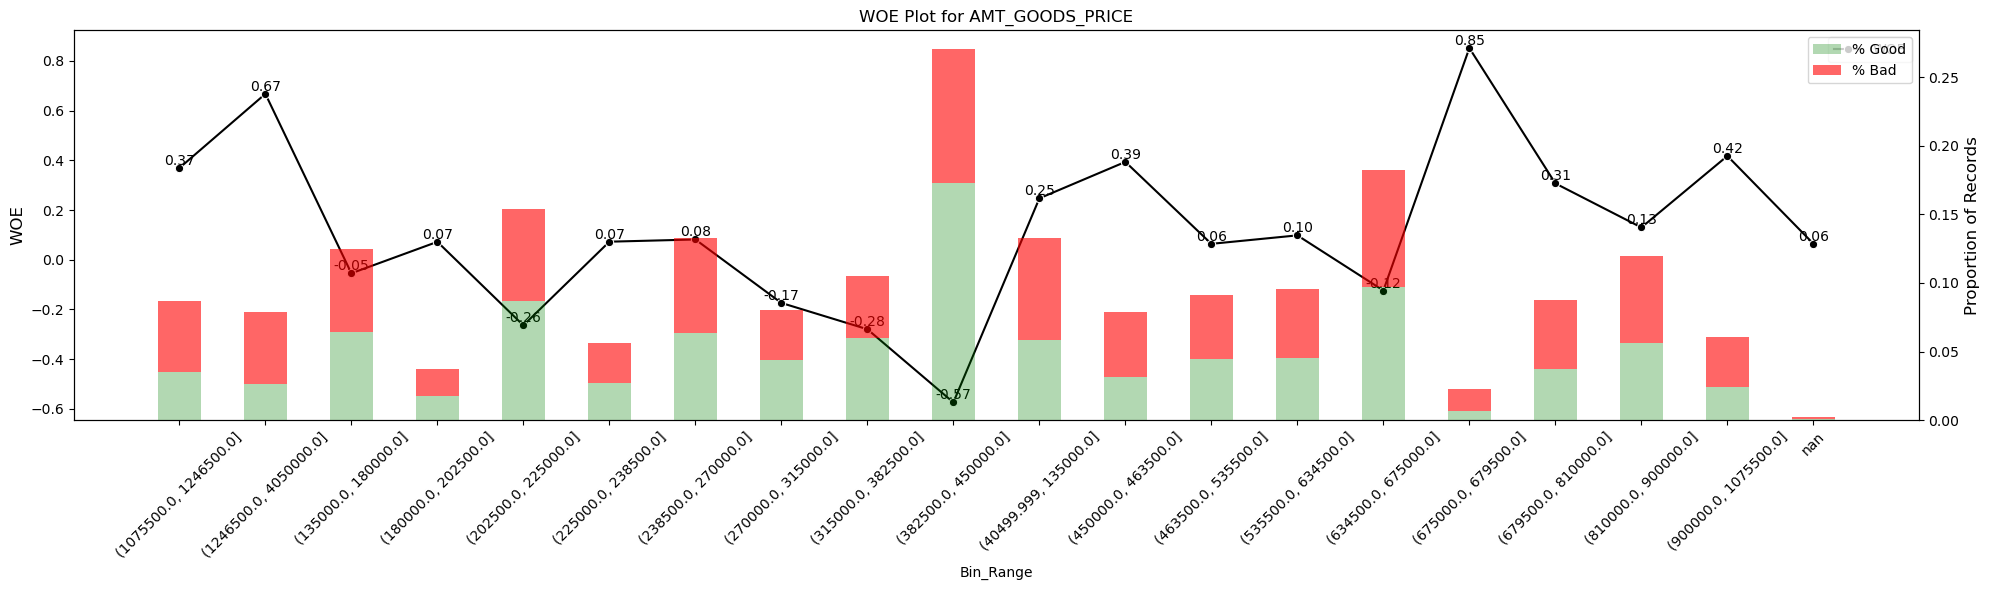


IV for AMT_GOODS_PRICE with 5 bins: 0.0379
WOE values per Bin_Range:
  (400000.0, 600000.0]: WOE = -0.200317
  (-0.001, 400000.0]: WOE = -0.056391
  (600000.0, 800000.0]: WOE = 0.067722
  (800000.0, 1100000.0]: WOE = 0.229937
  nan: WOE = 0.512904
IV for AMT_GOODS_PRICE with 5 bins: 0.0379


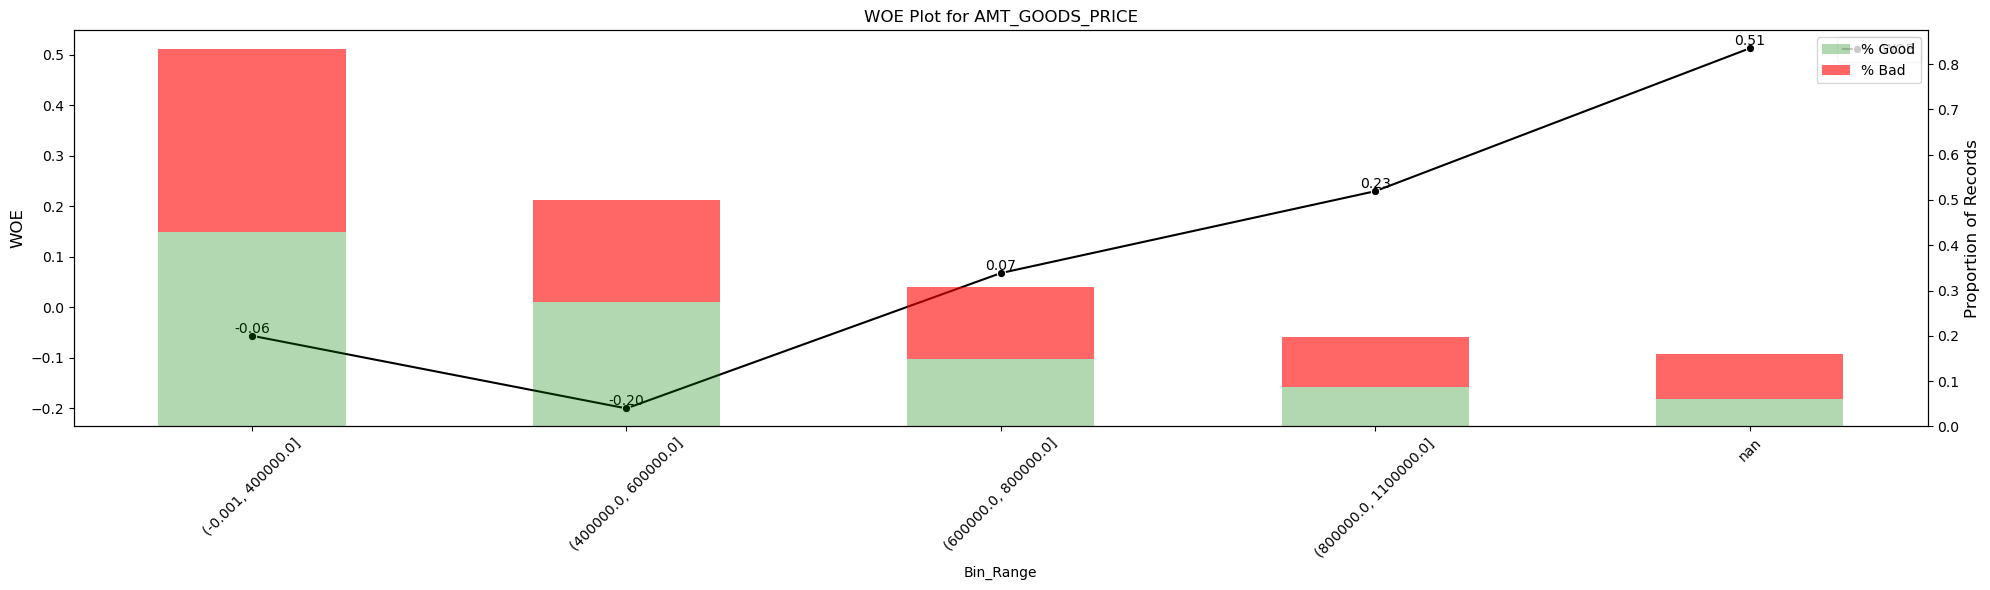

In [88]:
plot_numeric_woe(df, 'AMT_GOODS_PRICE', 20)
plot_numeric_woe_manual(df, 'AMT_GOODS_PRICE', [0,400000,600000,800000,1100000])

IV for DAYS_EMPLOYED with 17 bins: 0.1047


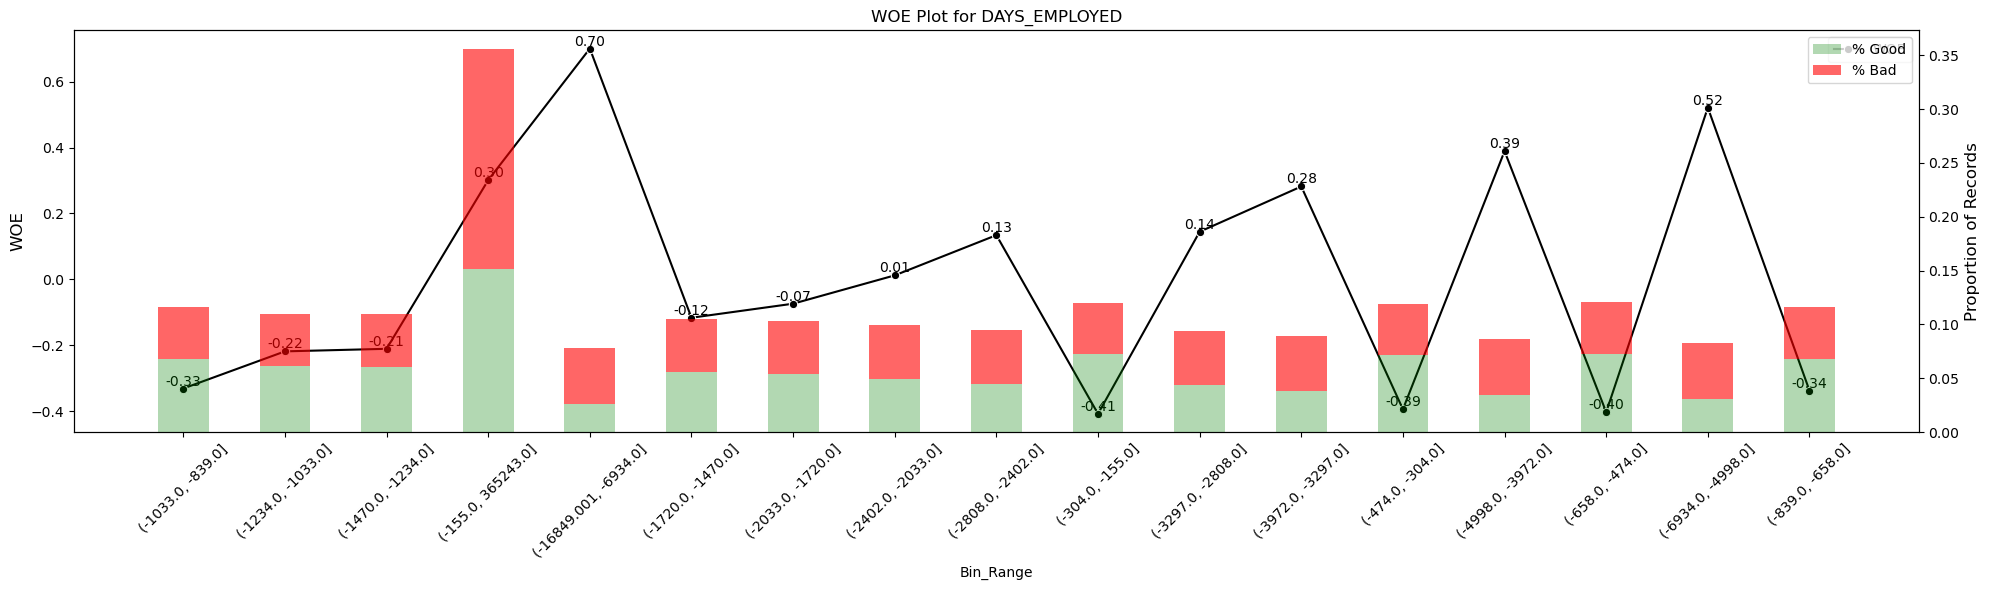


IV for DAYS_EMPLOYED with 4 bins: 0.1015
WOE values per Bin_Range:
  (-2000.0, 0.0]: WOE = -0.283358
  (-4000.0, -2000.0]: WOE = 0.137004
  nan: WOE = 0.441895
  (-8000.001, -4000.0]: WOE = 0.474667
IV for DAYS_EMPLOYED with 4 bins: 0.1015


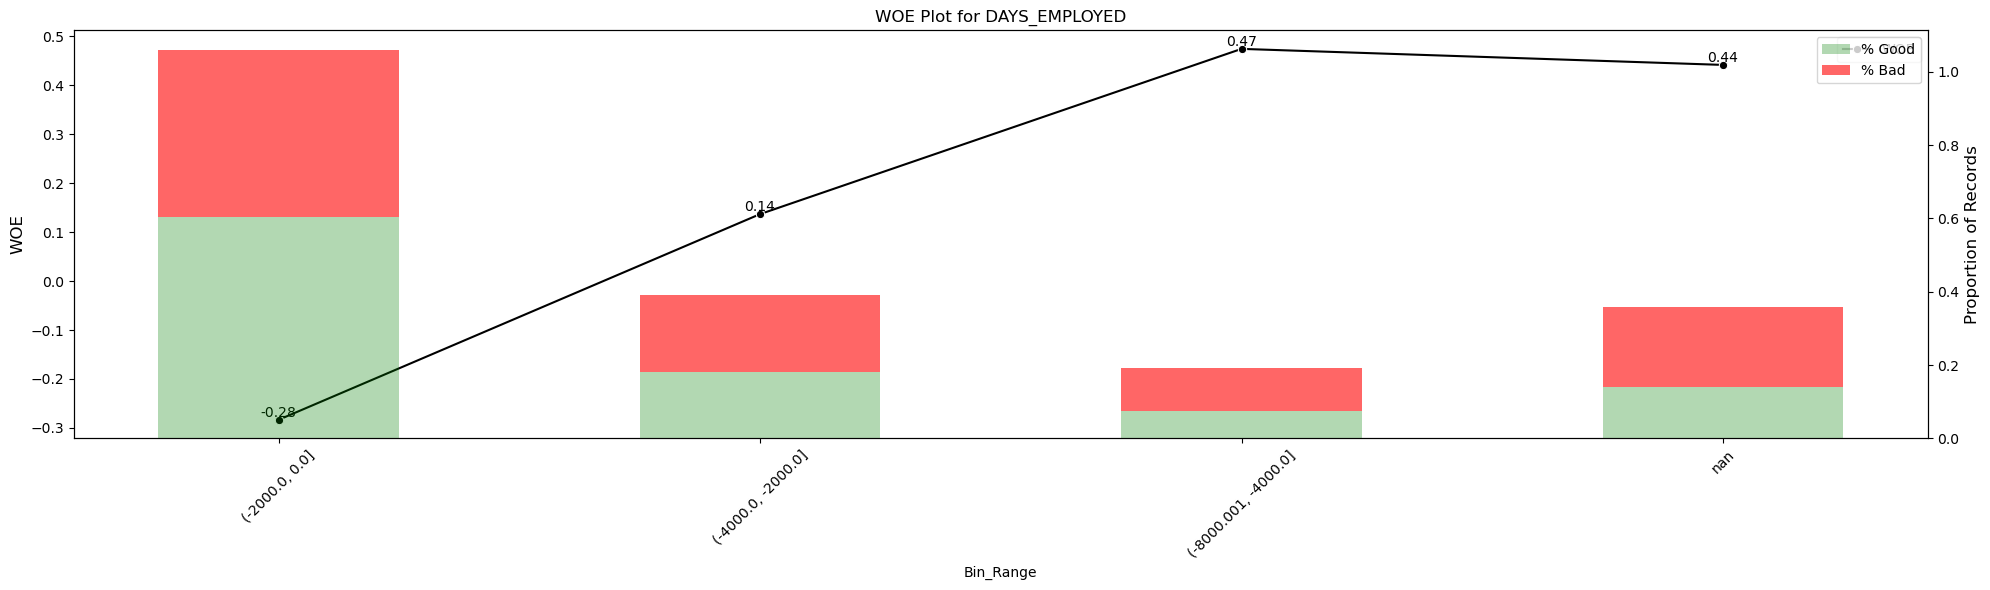

In [89]:
plot_numeric_woe(df, 'DAYS_EMPLOYED', 20)
plot_numeric_woe_manual(df, 'DAYS_EMPLOYED', [-8000, -4000, -2000, 0])

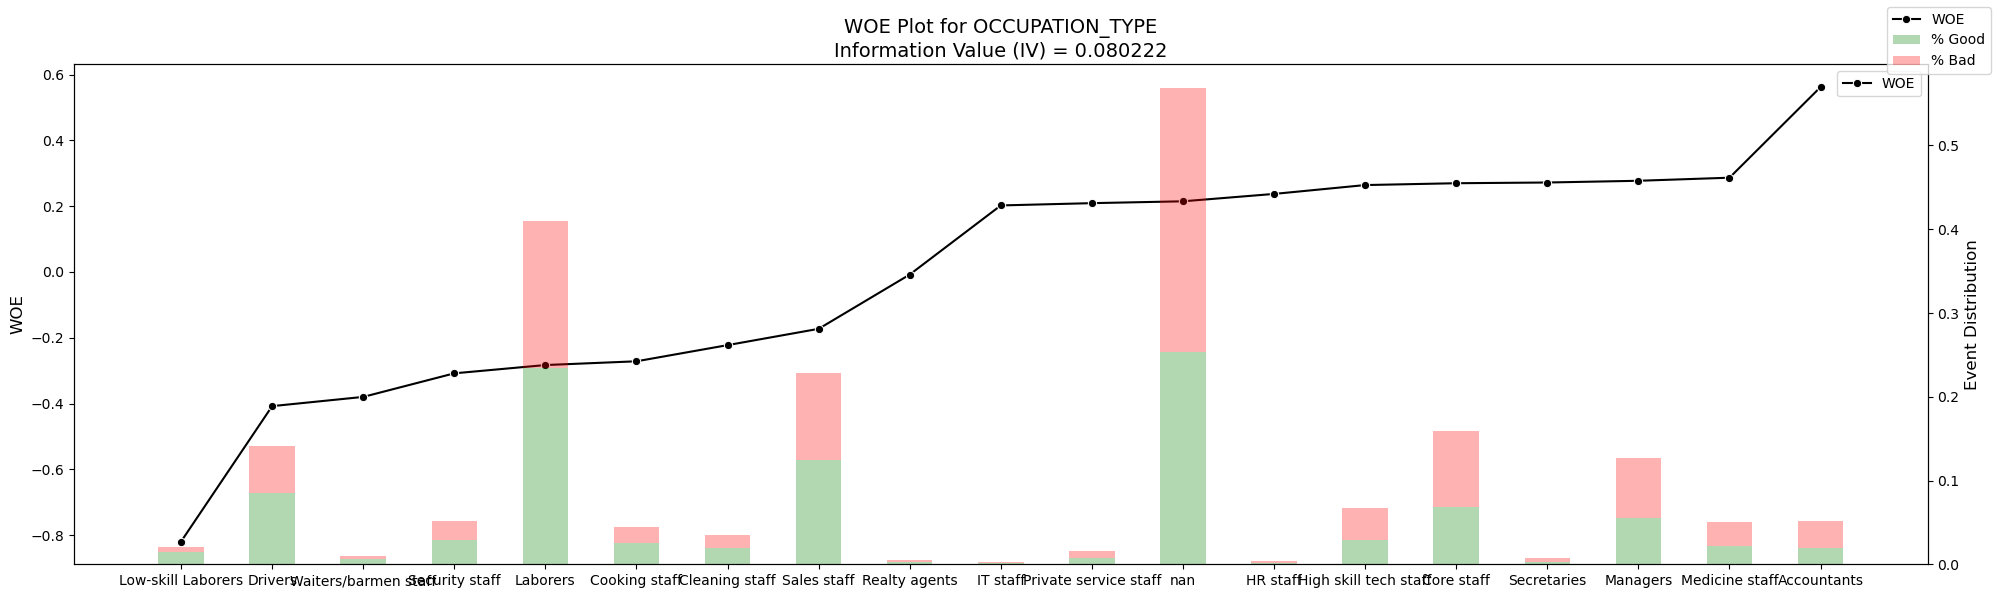

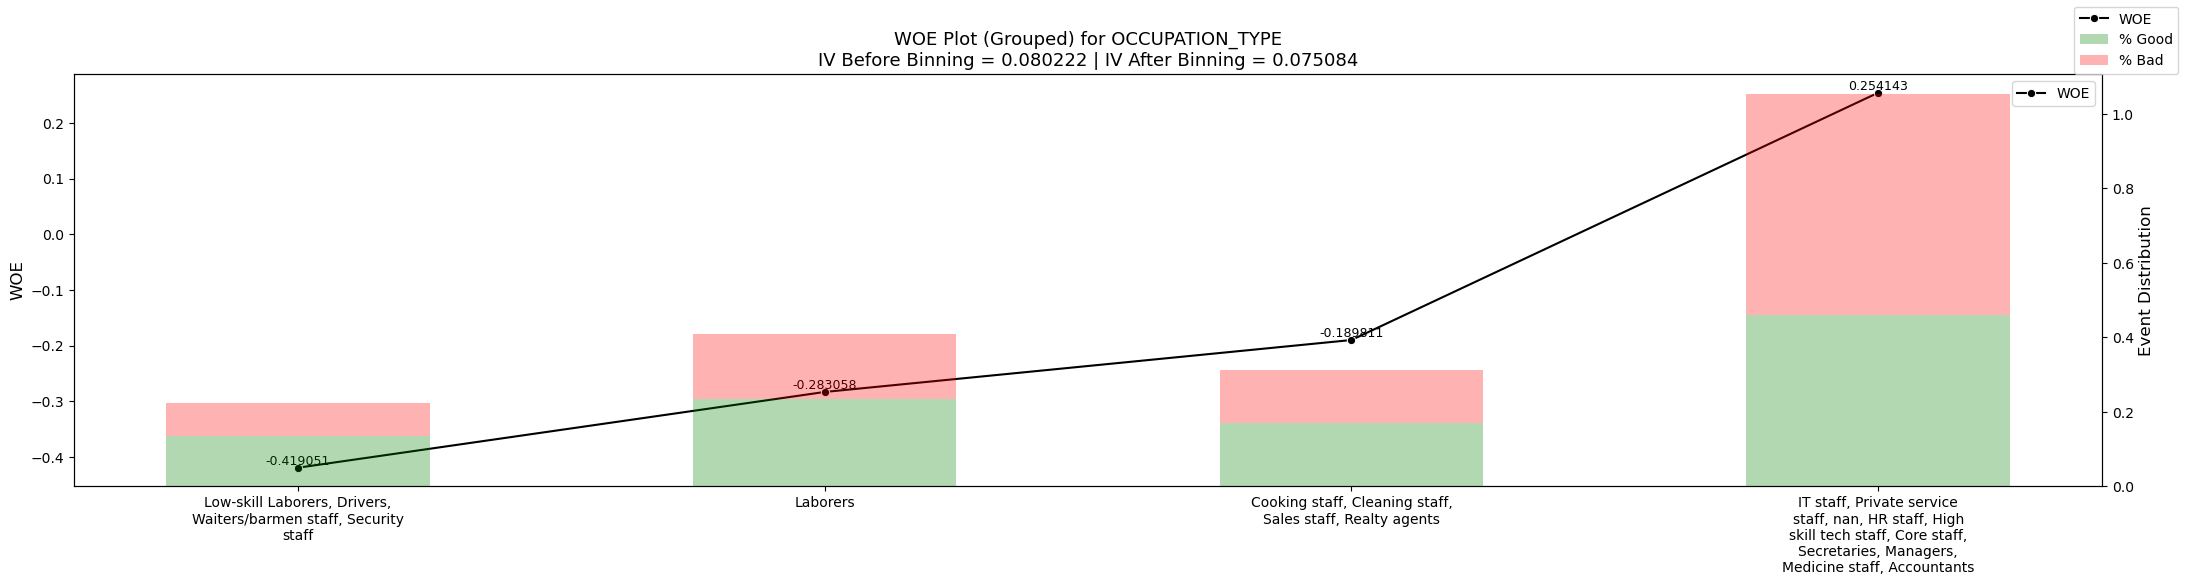


Information Value (IV) Before Binning: 0.080222
Information Value (IV) After Binning:  0.075084

WOE for each grouped bin:
Group 1:
  Categories: Low-skill Laborers, Drivers, Waiters/barmen staff, Security staff
  WOE: -0.419051

Group 2:
  Categories: Laborers
  WOE: -0.283058

Group 3:
  Categories: Cooking staff, Cleaning staff, Sales staff, Realty agents
  WOE: -0.189811

Group 4:
  Categories: IT staff, Private service staff, nan, HR staff, High skill tech staff, Core staff, Secretaries, Managers, Medicine staff, Accountants
  WOE: 0.254143



In [90]:
woe_iv_plot_categorical(df, "OCCUPATION_TYPE", target_name='TARGET')
woe_iv_plot_categorical_manual(df, "OCCUPATION_TYPE", [0,4,5,9,19], target_name='TARGET')

IV for DAYS_CREDIT_min with 21 bins: 0.0786


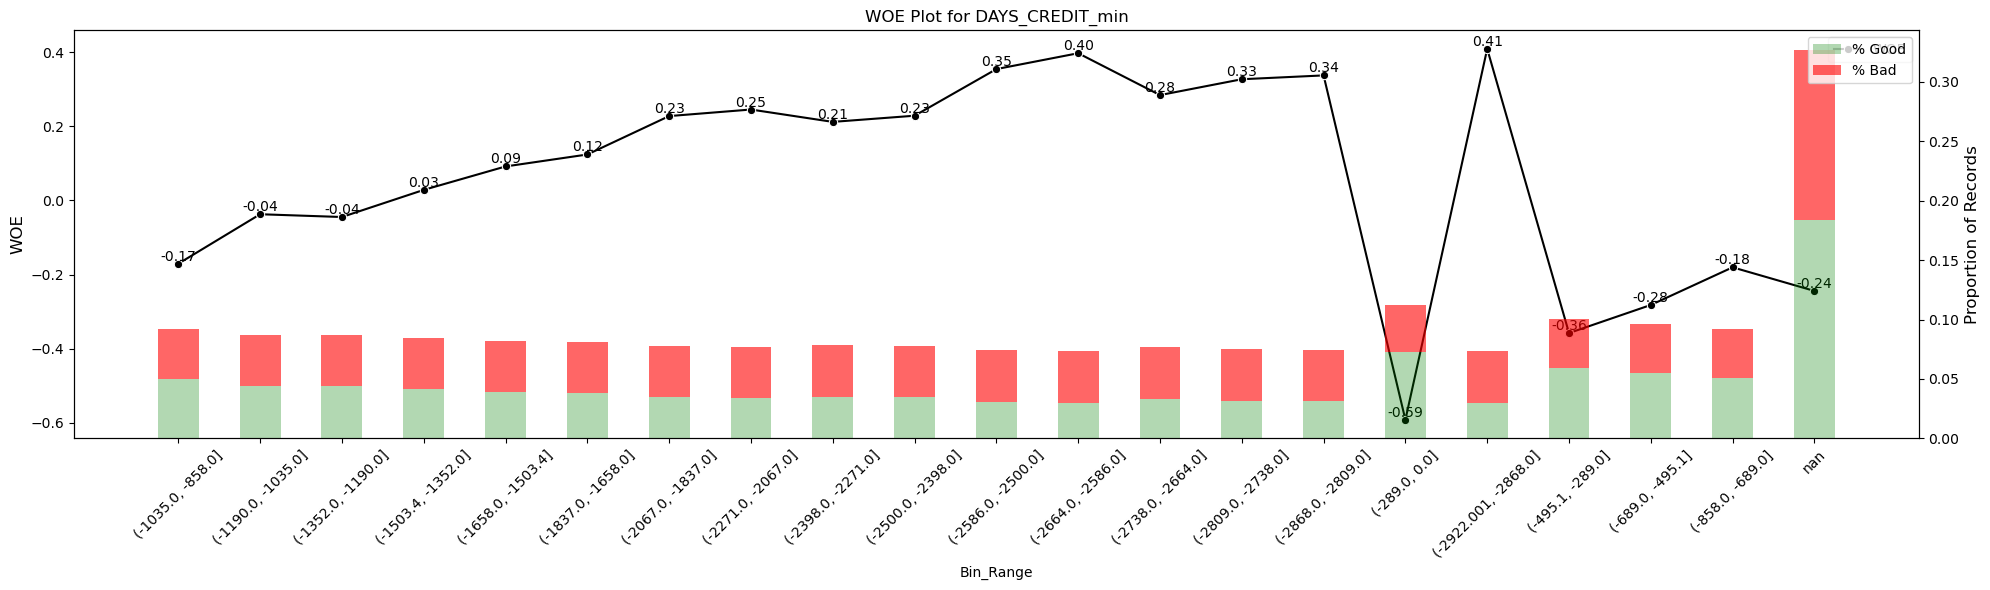


IV for DAYS_CREDIT_min with 5 bins: 0.0638
WOE values per Bin_Range:
  (-1000.0, -200.0]: WOE = -0.285150
  nan: WOE = -0.259792
  (-1500.0, -1000.0]: WOE = -0.025217
  (-2500.0, -1500.0]: WOE = 0.186869
  (-2900.001, -2500.0]: WOE = 0.346265
IV for DAYS_CREDIT_min with 5 bins: 0.0638


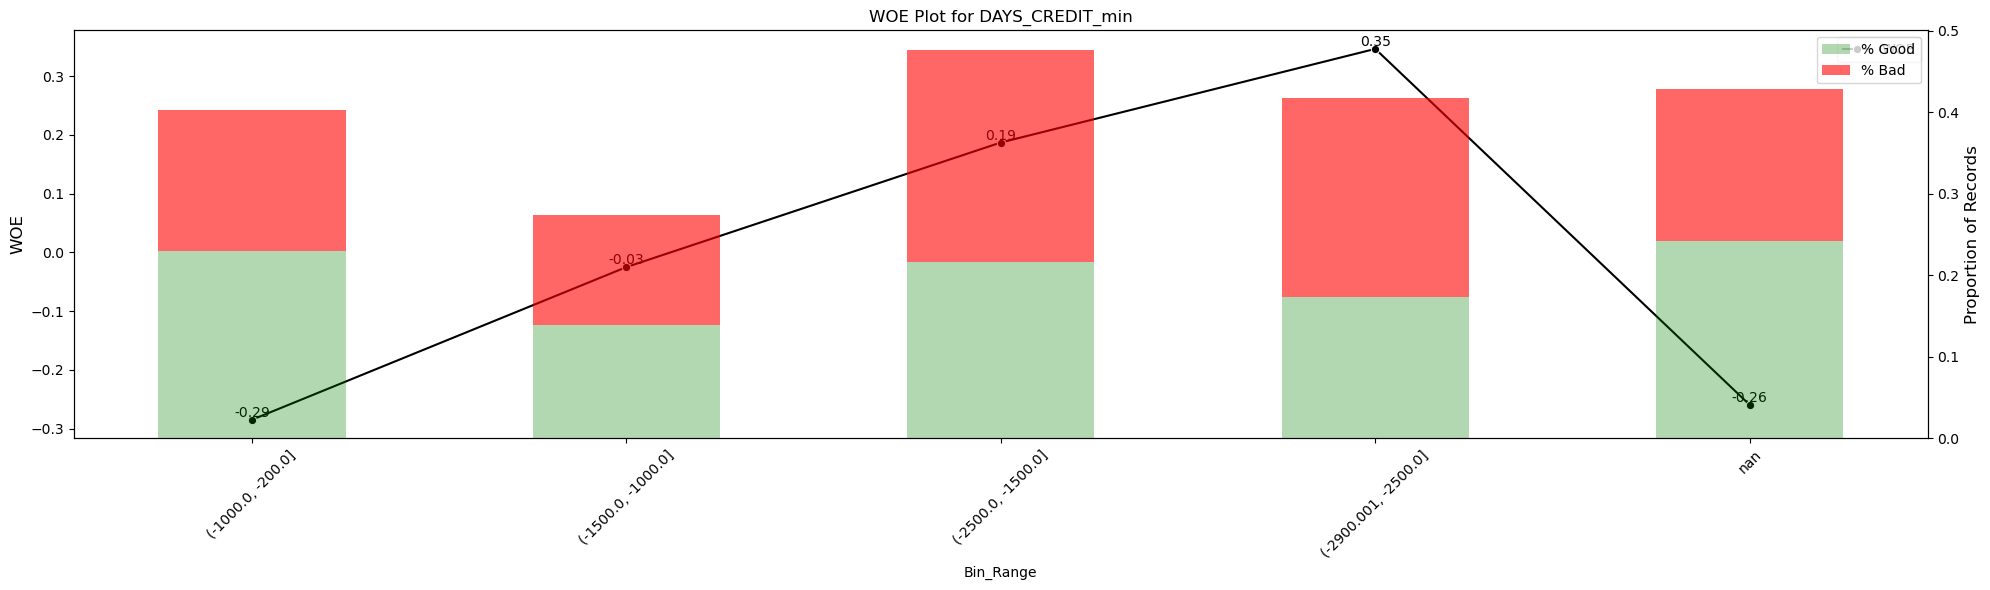

In [91]:
plot_numeric_woe(df, 'DAYS_CREDIT_min', 20)
plot_numeric_woe_manual(df, 'DAYS_CREDIT_min', [-2900,-2500,-1500, -1000, -200])

IV for DAYS_BIRTH with 20 bins: 0.0799


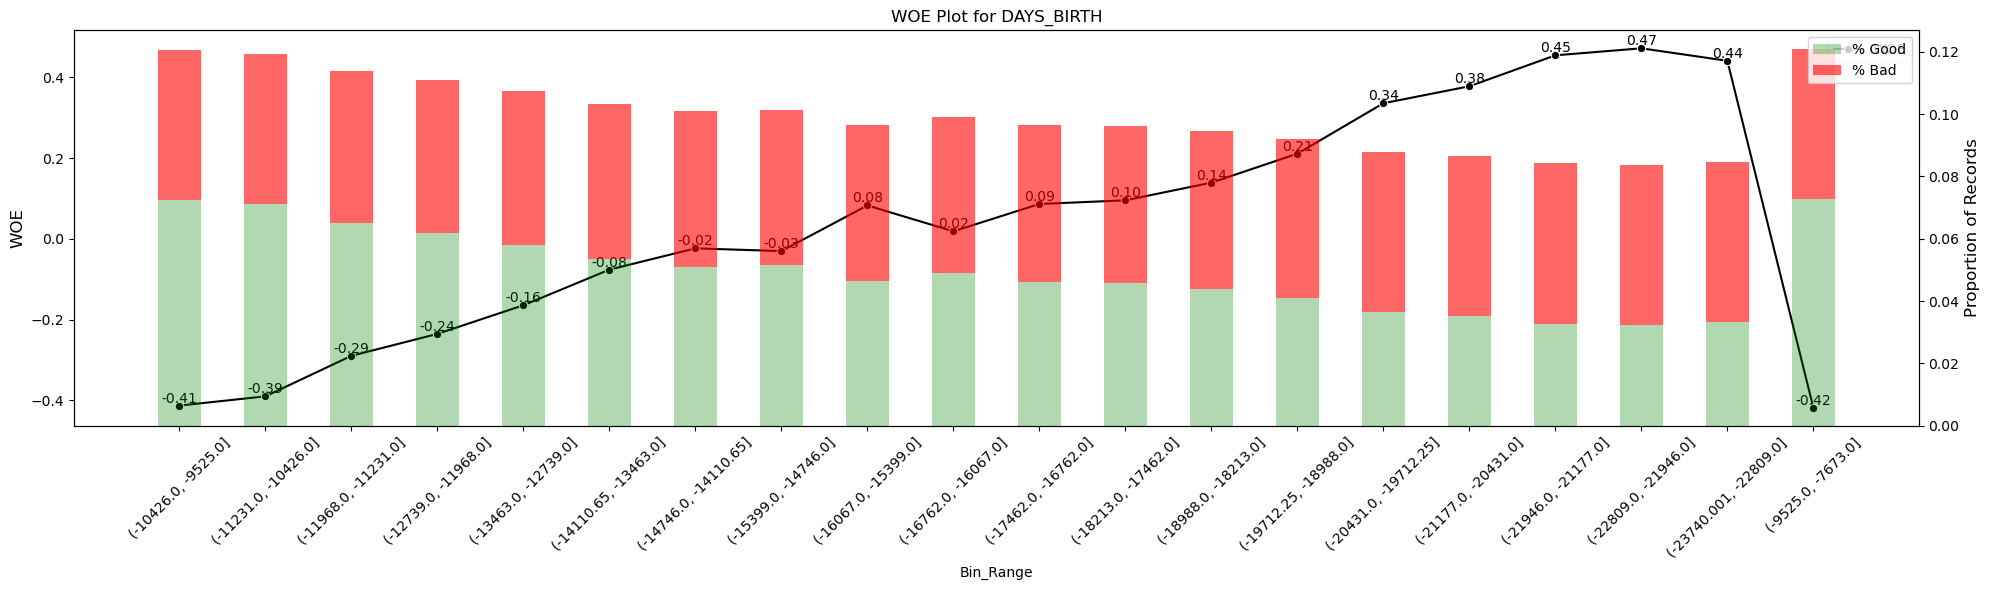


IV for DAYS_BIRTH with 4 bins: 0.074
WOE values per Bin_Range:
  (-12000.0, 0.0]: WOE = -0.375785
  (-16000.0, -12000.0]: WOE = -0.078295
  (-20000.0, -16000.0]: WOE = 0.115700
  (-24000.001, -20000.0]: WOE = 0.429060
IV for DAYS_BIRTH with 4 bins: 0.074


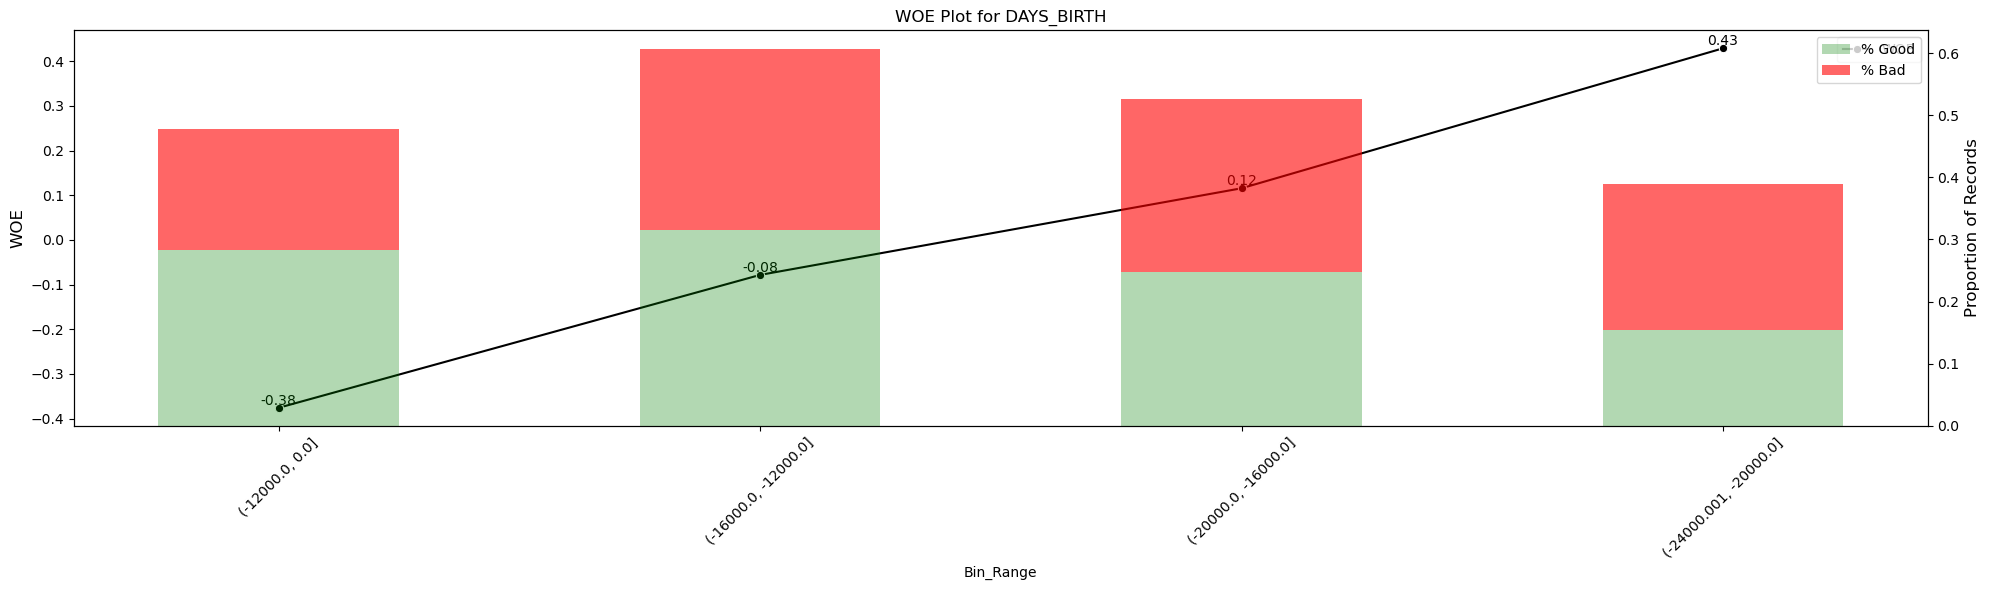

In [92]:
plot_numeric_woe(df, 'DAYS_BIRTH', 20)
plot_numeric_woe_manual(df, 'DAYS_BIRTH', [-24000, -20000,-16000, -12000, 0])

In [105]:
plot_numeric_woe(df, 'DAYS_CREDIT_ENDDATE_mean', 20)
plot_numeric_woe_manual(df, 'DAYS_CREDIT_ENDDATE_mean', [-41800,-500,-200, 200, 32000])

KeyError: 'DAYS_CREDIT_ENDDATE_mean'

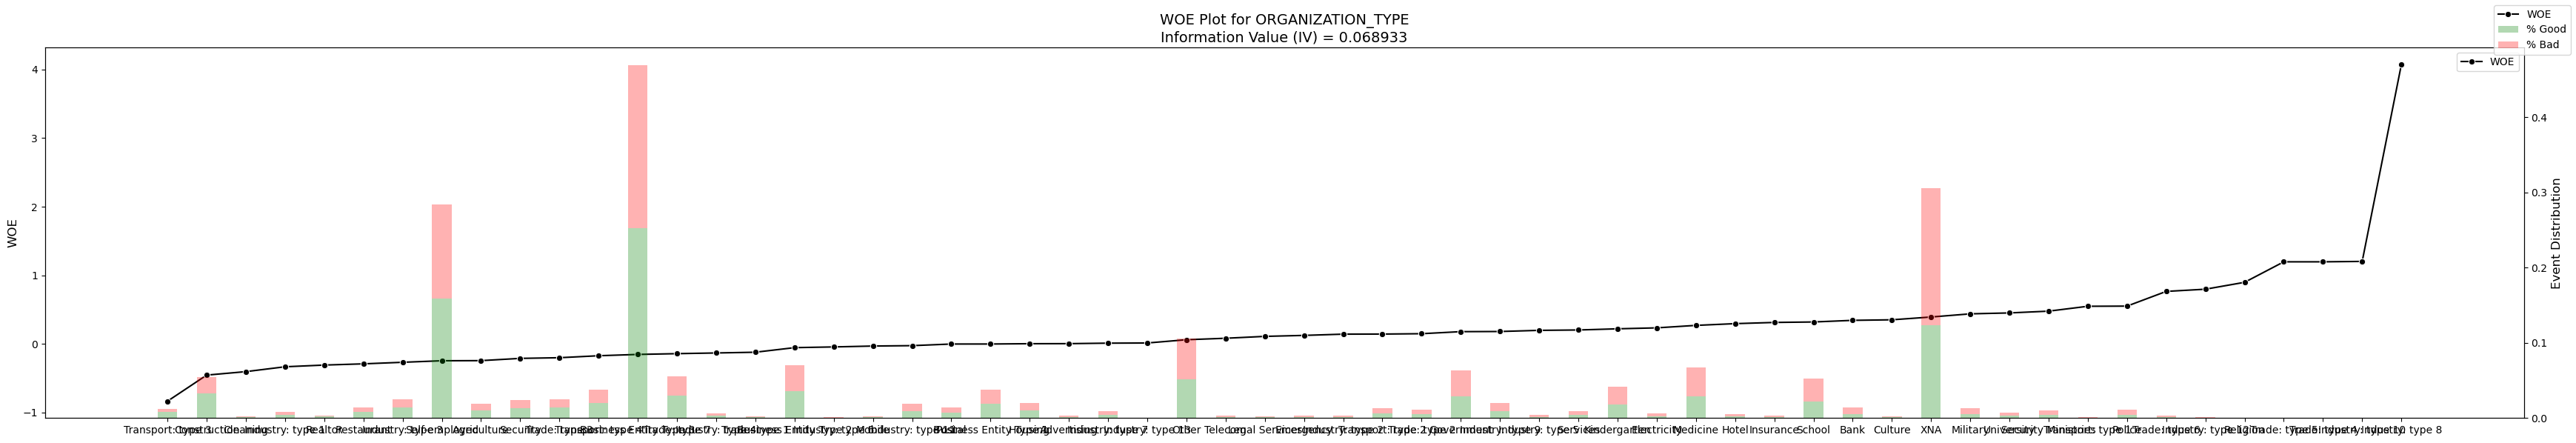

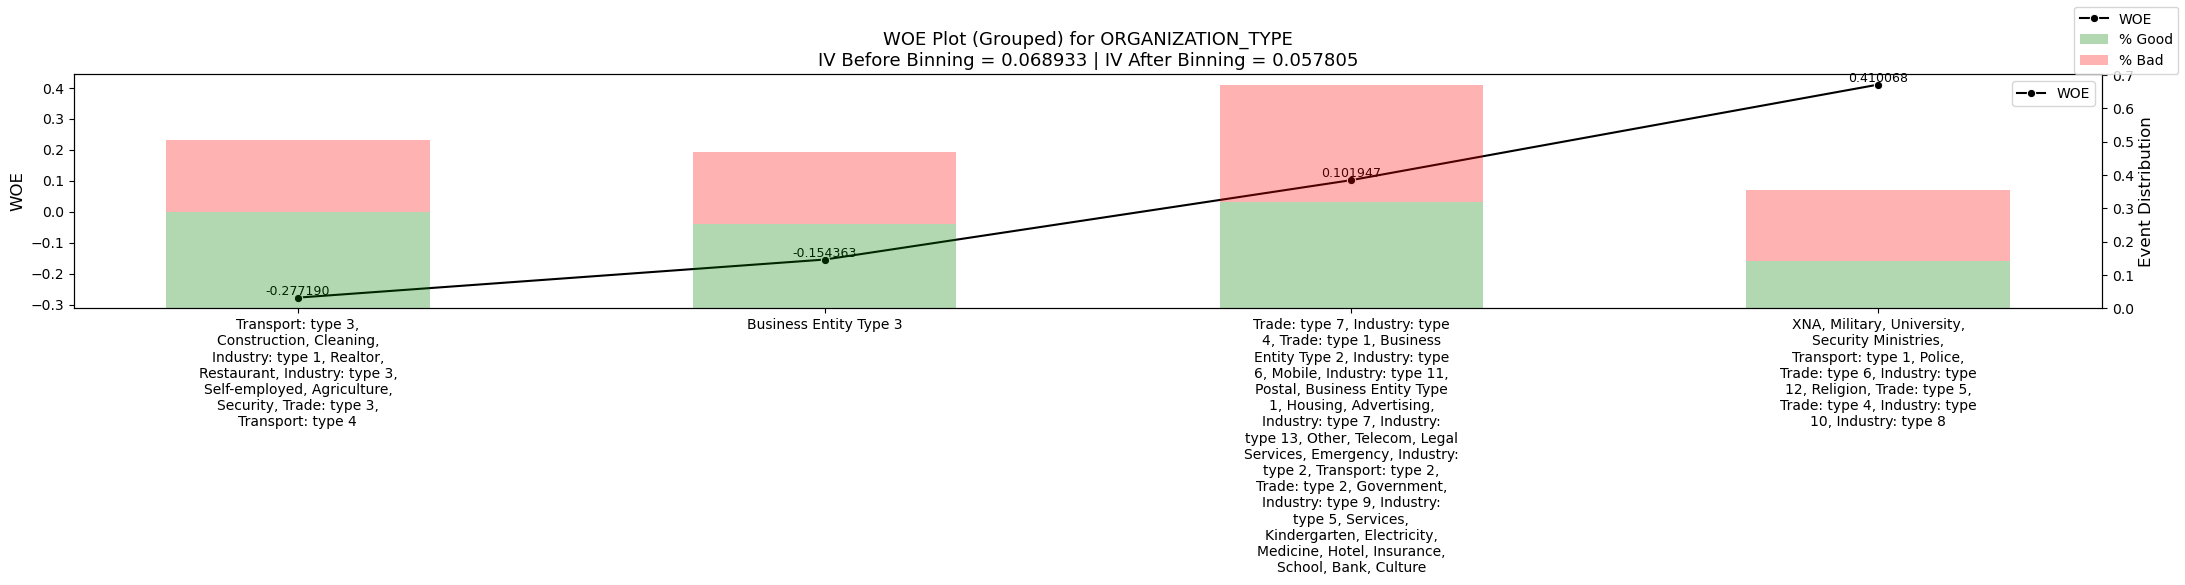


Information Value (IV) Before Binning: 0.068933
Information Value (IV) After Binning:  0.057805

WOE for each grouped bin:
Group 1:
  Categories: Transport: type 3, Construction, Cleaning, Industry: type 1, Realtor, Restaurant, Industry: type 3, Self-employed, Agriculture, Security, Trade: type 3, Transport: type 4
  WOE: -0.277190

Group 2:
  Categories: Business Entity Type 3
  WOE: -0.154363

Group 3:
  Categories: Trade: type 7, Industry: type 4, Trade: type 1, Business Entity Type 2, Industry: type 6, Mobile, Industry: type 11, Postal, Business Entity Type 1, Housing, Advertising, Industry: type 7, Industry: type 13, Other, Telecom, Legal Services, Emergency, Industry: type 2, Transport: type 2, Trade: type 2, Government, Industry: type 9, Industry: type 5, Services, Kindergarten, Electricity, Medicine, Hotel, Insurance, School, Bank, Culture
  WOE: 0.101947

Group 4:
  Categories: XNA, Military, University, Security Ministries, Transport: type 1, Police, Trade: type 6, Industry:

In [94]:
woe_iv_plot_categorical(df, "ORGANIZATION_TYPE", target_name='TARGET')
woe_iv_plot_categorical_manual(df, "ORGANIZATION_TYPE", [0,12,13,45,60], target_name='TARGET')

IV for AMT_CREDIT_SUM_DEBT_mean with 17 bins: 0.0541


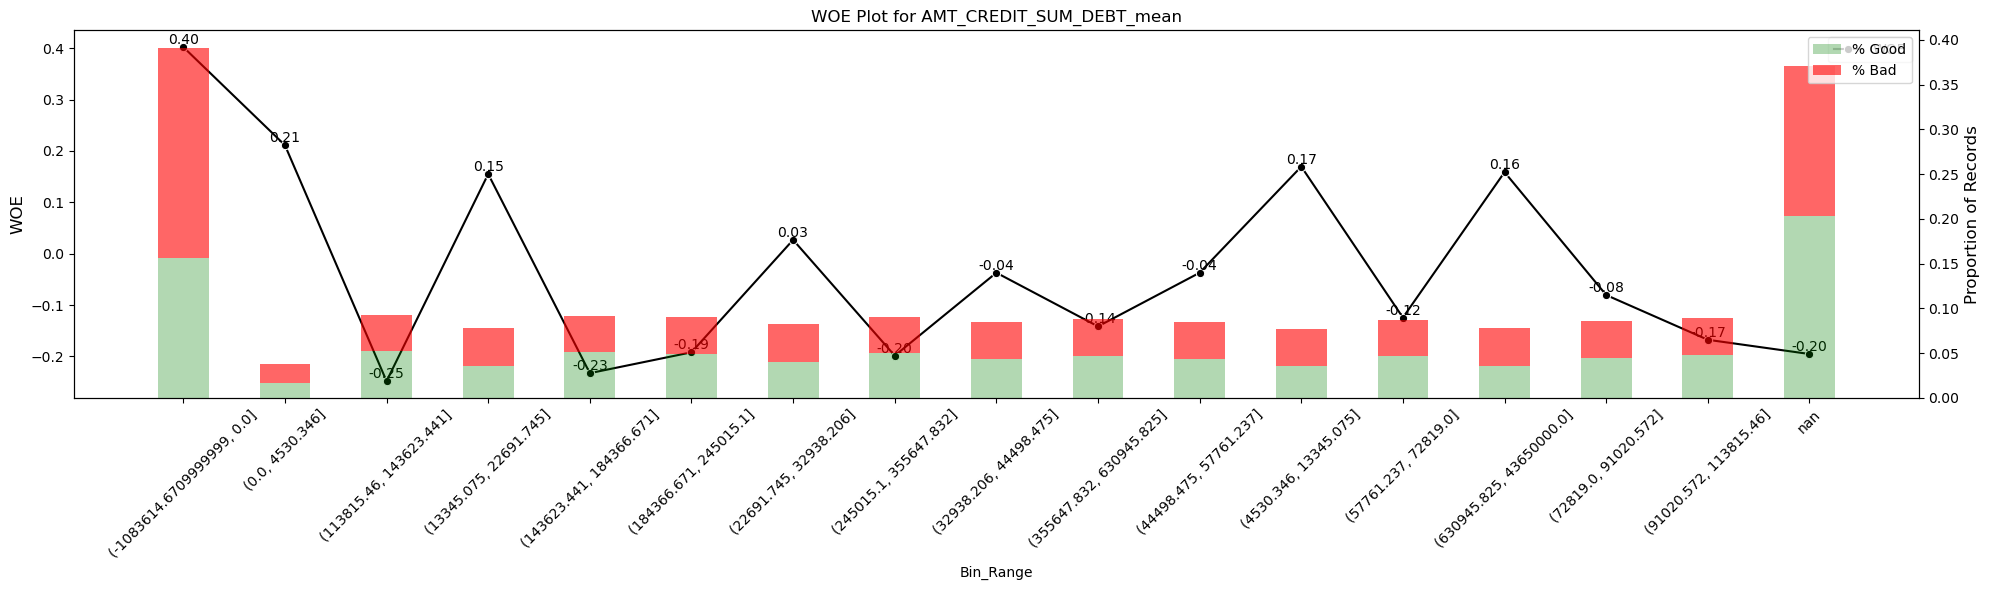


IV for AMT_CREDIT_SUM_DEBT_mean with 3 bins: 0.0436
WOE values per Bin_Range:
  nan: WOE = -0.167258
  (2000.0, 120000.0]: WOE = -0.016294
  (-2000000.001, 2000.0]: WOE = 0.393519
IV for AMT_CREDIT_SUM_DEBT_mean with 3 bins: 0.0436


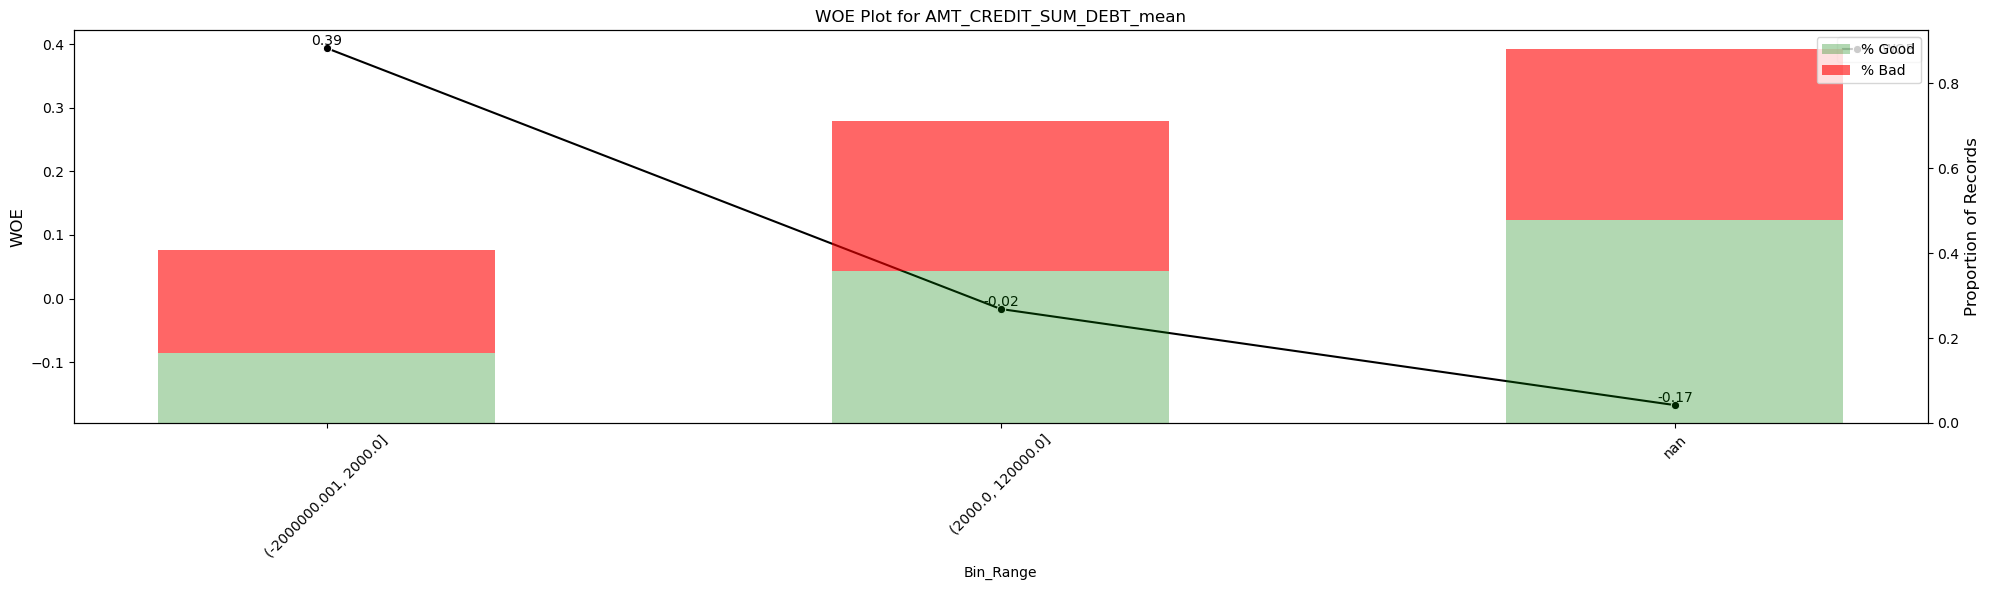

In [106]:
plot_numeric_woe(df, 'AMT_CREDIT_SUM_DEBT_mean', 20)
plot_numeric_woe_manual(df, 'AMT_CREDIT_SUM_DEBT_mean', [-2000000,2000, 120000])
# why are the ranges so weird? what does this even mean

IV for OWN_CAR_AGE with 20 bins: 0.0227


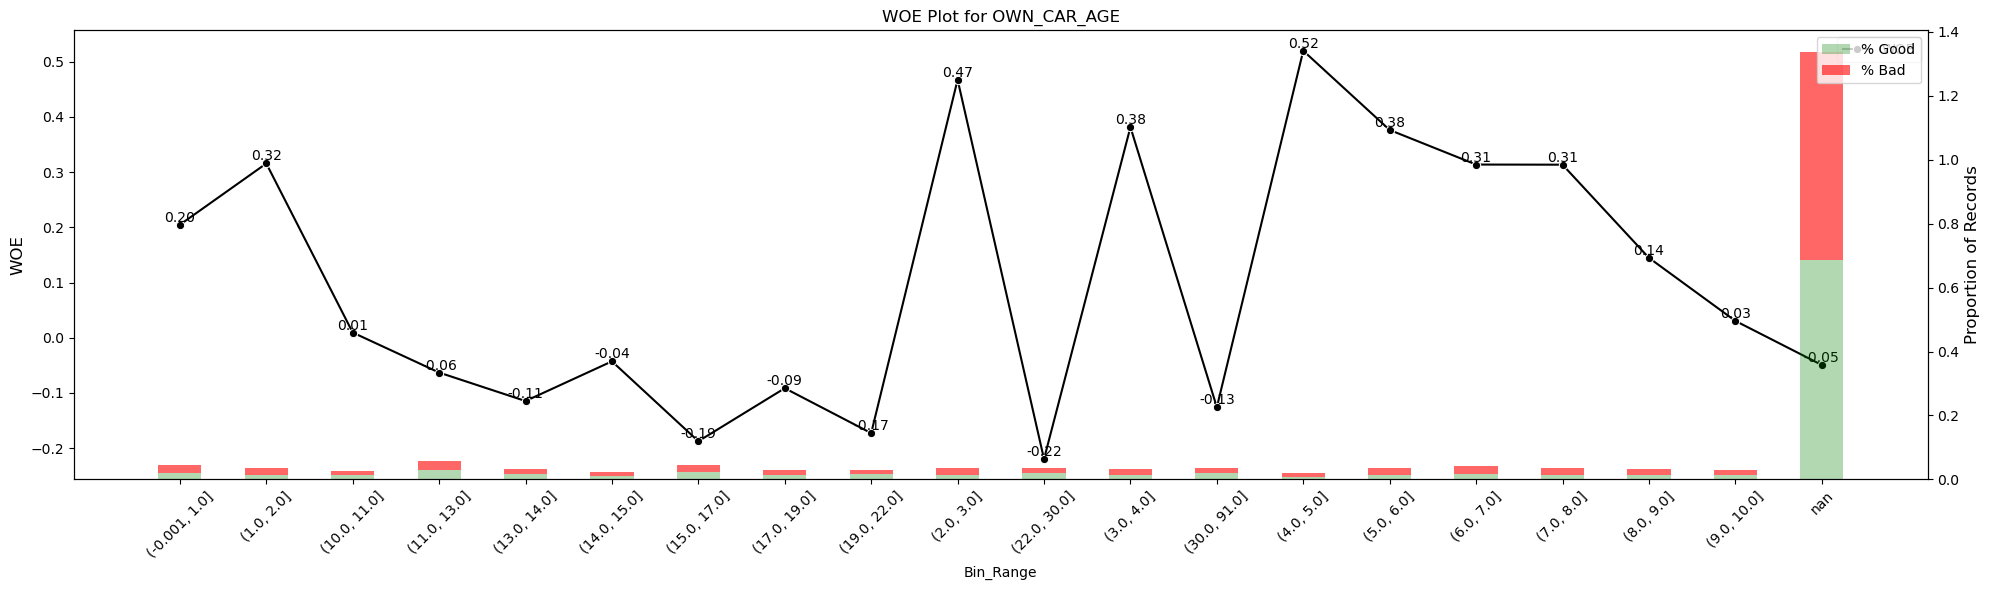


IV for OWN_CAR_AGE with 5 bins: 0.0193
WOE values per Bin_Range:
  nan: WOE = 0.353993
  nan: WOE = -0.057231
  nan: WOE = -0.149858
  nan: WOE = 0.245325
  nan: WOE = -0.057318
IV for OWN_CAR_AGE with 5 bins: 0.0193


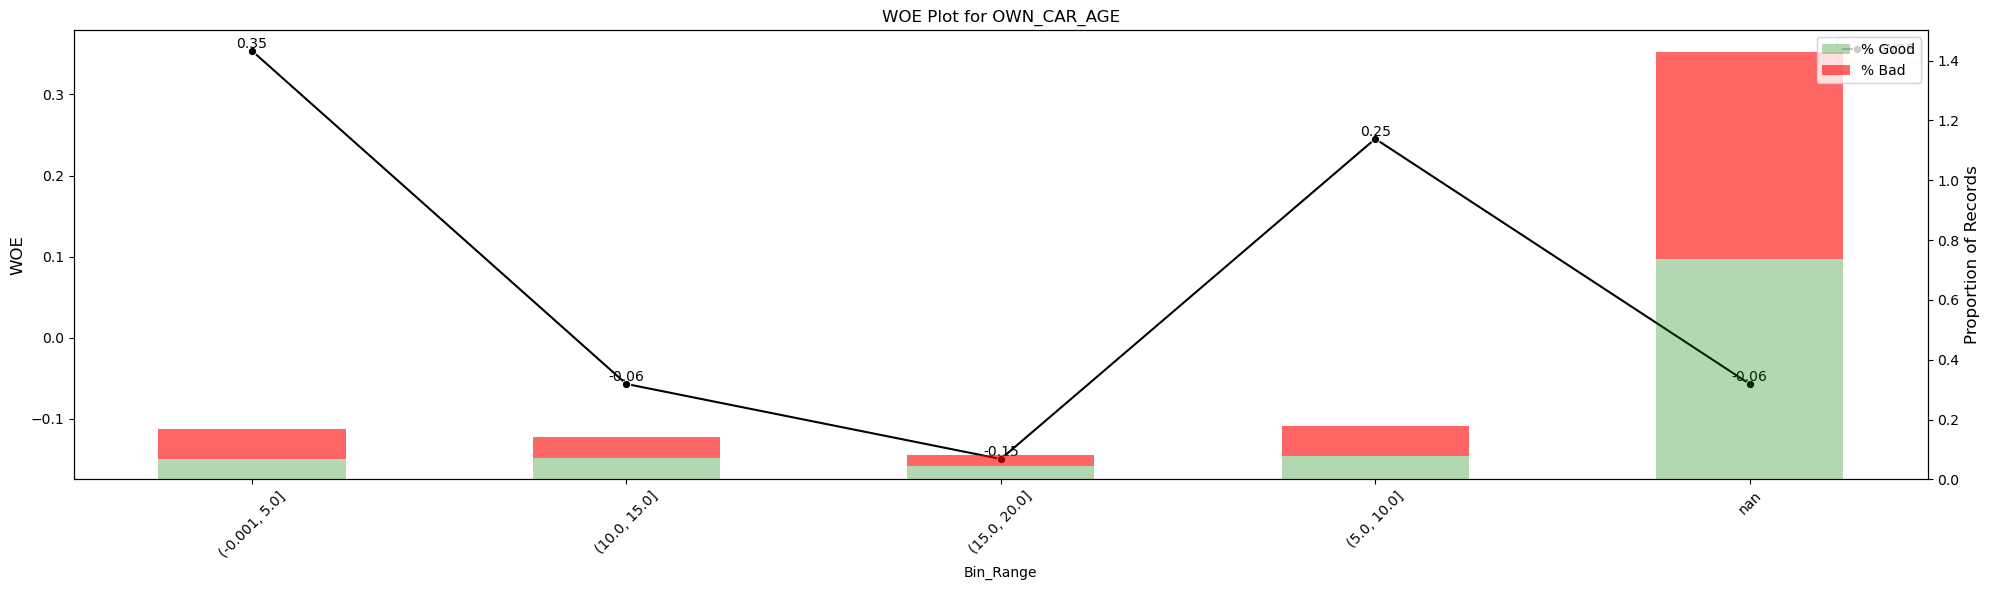

In [70]:
plot_numeric_woe(df, 'OWN_CAR_AGE', 20)
plot_numeric_woe_manual(df, 'OWN_CAR_AGE', [0 , 5, 10, 15 , 20])

In [72]:
# drop unwatned variables and save new df as after_coarse_classing
cols_to_drop = [
    'OWN_CAR_AGE',
    'AMT_GOODS_PRICE',
    'DAYS_CREDIT_ENDDATE_mean',
]

df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)
df.info()
df.to_csv('after_coarse_classing.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 207300 entries, 0 to 307509
Data columns (total 9 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   TARGET                    207300 non-null  int64  
 1   NAME_INCOME_TYPE          207300 non-null  object 
 2   DAYS_BIRTH                207300 non-null  int64  
 3   DAYS_EMPLOYED             207300 non-null  int64  
 4   OCCUPATION_TYPE           207300 non-null  object 
 5   ORGANIZATION_TYPE         207300 non-null  object 
 6   EXT_SOURCE_1              89268 non-null   float64
 7   DAYS_CREDIT_min           176852 non-null  float64
 8   AMT_CREDIT_SUM_DEBT_mean  172010 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 15.8+ MB


<h1> Create Scorecard

In [100]:
def Encode_WOE_categorical(column, bin_ranges, woe_values, output_df, missing_woe_value):
    """
    Encode a categorical column into WOE using manual groupings and handle missing values.
    
    Parameters:
    - column: pandas Series (e.g. original_df['JOB'])
    - bin_ranges: list of grouped category strings (e.g., ['student,unemployed', 'working'])
    - woe_values: WOE values for each group (e.g., [-0.2, 0.4])
    - output_df: DataFrame to which the new column will be added
    - missing_woe_value: WOE value to assign to missing or unmapped values
    """
    col_name = column.name + '_woe'

    # Step 1: Build category-to-WOE mapping
    group_to_woe = {}
    for group_str, woe_val in zip(bin_ranges, woe_values):
        categories = [cat.strip() for cat in group_str.split(',')]
        for cat in categories:
            group_to_woe[cat] = float(woe_val)

    # Step 2: Map values and handle missing/unmapped
    encoded_col = column.fillna('Missing').astype(str).map(group_to_woe).fillna(float(missing_woe_value))

    # Step 3: Add to output DataFrame
    output_df[col_name] = encoded_col

In [101]:
def Encode_WOE_numerical(column, bin_edges, woe_values, output_df, missing_woe_value):
    """
    Encode a numerical column into WOE using manual bins and handle missing values.

    Parameters:
    - column: pandas Series (e.g. original_df['EXT_SOURCE_1'])
    - bin_edges: list of numeric cut points
    - woe_values: WOE values for each bin (len = len(bin_edges) - 1)
    - output_df: DataFrame to which the encoded column will be added
    - missing_woe_value: WOE value to assign to missing values
    """
    col_name = column.name + '_woe'

    # Step 1: Bin the values
    binned = pd.cut(column, bins=bin_edges, include_lowest=True)

    # Step 2: Map each bin to WOE
    bin_labels = binned.cat.categories
    if len(woe_values) != len(bin_labels):
        raise ValueError(f"Number of WOE values ({len(woe_values)}) must match number of bins ({len(bin_labels)})")

    bin_to_woe = {bin_labels[i]: float(woe_values[i]) for i in range(len(woe_values))}

    # Step 3: Map and handle missing values
    encoded_col = binned.map(bin_to_woe).astype(float).fillna(float(missing_woe_value))

    # Step 4: Add to output DataFrame
    output_df[col_name] = encoded_col

In [102]:
encoded_df = pd.DataFrame()
df = pd.read_csv('after_coarse_classing.csv')
encoded_df['TARGET'] = df['TARGET']
encoded_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207300 entries, 0 to 207299
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   TARGET  207300 non-null  int64
dtypes: int64(1)
memory usage: 1.6 MB


In [103]:
Encode_WOE_categorical(
    df['NAME_INCOME_TYPE'],
    bin_ranges=['Maternity leave, Unemployed, Working', 'Commercial associate','State servant, Pensioner, Businessman, Student'],
    woe_values=[-0.174844, 0.068848, 0.389268],
    output_df = encoded_df,
    missing_woe_value=0.0
)

In [107]:
Encode_WOE_numerical(
    df['DAYS_BIRTH'],
    bin_edges=[-24000, -20000, -16000, -12000, 0],
    woe_values=[0.429060, 0.115700, -0.078295, -0.375785],
    output_df=encoded_df,
    missing_woe_value=0
)
encoded_df.head(10)

,TARGET,NAME_INCOME_TYPE_woe,DAYS_BIRTH_woe
0,1,-0.174844,-0.375785
1,0,-0.174844,0.115700
2,0,-0.174844,0.115700
3,0,-0.174844,0.115700
4,0,0.389268,0.115700
5,0,0.068848,-0.078295
6,0,0.389268,0.115700
7,0,0.389268,0.429060
8,0,-0.174844,-0.078295
9,0,-0.174844,-0.375785


In [109]:
Encode_WOE_numerical(
    df['DAYS_EMPLOYED'],
    bin_edges=[-8000, -4000, -2000, 0],
    woe_values=[0.474667, 0.137004, -0.283358],
    output_df=encoded_df,
    missing_woe_value= 0.441895
)



In [110]:
Encode_WOE_categorical(
    df['OCCUPATION_TYPE'],
    bin_ranges=['Low-skill Laborers,Drivers,Waiters/barmen staff,Security staff', 'Laborers', 'Cooking staff,Cleaning staff,Sales staff,Realty agents', 'IT staff,Private service staff,Missing,HR staff,High skill tech staff,Core staff,Secretaries,Managers,Medicine staff,Accountants'],
    woe_values=[-0.419055, -0.283060, -0.189812, 0.254144],
    output_df = encoded_df,
    missing_woe_value=0.0
)
encoded_df.head(10)

,TARGET,NAME_INCOME_TYPE_woe,DAYS_BIRTH_woe,DAYS_EMPLOYED_woe,OCCUPATION_TYPE_woe
0,1,-0.174844,-0.375785,-0.283358,-0.283060
1,0,-0.174844,0.115700,-0.283358,-0.283060
2,0,-0.174844,0.115700,0.137004,-0.283060
3,0,-0.174844,0.115700,0.137004,0.254144
4,0,0.389268,0.115700,-0.283358,-0.283060
5,0,0.068848,-0.078295,0.137004,0.254144
6,0,0.389268,0.115700,-0.283358,0.254144
7,0,0.389268,0.429060,0.441895,0.254144
8,0,-0.174844,-0.078295,0.137004,-0.283060
9,0,-0.174844,-0.375785,-0.283358,0.254144


In [111]:
Encode_WOE_categorical(
    df['ORGANIZATION_TYPE'],
    bin_ranges=['Transport: type 3,Construction,Cleaning,Industry: type 1,Realtor,Restaurant,Industry: type 3,Self-employed,Agriculture,Security,Trade: type 3,Transport: type 4', 'Business Entity Type 3', 'Trade: type 7,Industry: type 4,Trade: type 1,Business Entity Type 2,Industry: type 6,Mobile,Industry: type 11,Postal,Business Entity Type 1,Housing,Advertising,Industry: type 7,Industry: type 13,Other,Telecom,Legal Services,Emergency,Industry: type 2,Transport: type 2,Trade: type 2,Government,Industry: type 9,Industry: type 5,Services,Kindergarten,Electricity,Medicine,Hotel,Insurance,School,Bank,Culture', 'XNA,Military,University,Security Ministries,Transport: type 1,Police,Trade: type 6,Industry: type 12,Religion,Trade: type 5,Trade: type 4,Industry: type 10,Industry: type 8'],
    woe_values=[-0.277191, -0.154363, 0.101947, 0.410070],
    output_df = encoded_df,
    missing_woe_value=0.0
)
encoded_df.head(10)

,TARGET,NAME_INCOME_TYPE_woe,DAYS_BIRTH_woe,DAYS_EMPLOYED_woe,OCCUPATION_TYPE_woe,ORGANIZATION_TYPE_woe
0,1,-0.174844,-0.375785,-0.283358,-0.283060,-0.154363
1,0,-0.174844,0.115700,-0.283358,-0.283060,0.101947
2,0,-0.174844,0.115700,0.137004,-0.283060,-0.154363
3,0,-0.174844,0.115700,0.137004,0.254144,0.410070
4,0,0.389268,0.115700,-0.283358,-0.283060,0.101947
5,0,0.068848,-0.078295,0.137004,0.254144,-0.154363
6,0,0.389268,0.115700,-0.283358,0.254144,0.101947
7,0,0.389268,0.429060,0.441895,0.254144,0.410070
8,0,-0.174844,-0.078295,0.137004,-0.283060,0.101947
9,0,-0.174844,-0.375785,-0.283358,0.254144,0.101947


In [112]:
Encode_WOE_numerical(
    df['EXT_SOURCE_1'],
    bin_edges=[-1, 0.2, 0.4, 0.6, 0.8, 1],
    woe_values=[-0.944106, -0.286090, 0.220194, 0.715798, 1.255758],
    output_df=encoded_df,
    missing_woe_value= -0.066502
)
encoded_df.head(10)

,TARGET,NAME_INCOME_TYPE_woe,DAYS_BIRTH_woe,DAYS_EMPLOYED_woe,OCCUPATION_TYPE_woe,ORGANIZATION_TYPE_woe,EXT_SOURCE_1_woe
0,1,-0.174844,-0.375785,-0.283358,-0.283060,-0.154363,-0.944106
1,0,-0.174844,0.115700,-0.283358,-0.283060,0.101947,-0.066502
2,0,-0.174844,0.115700,0.137004,-0.283060,-0.154363,-0.066502
3,0,-0.174844,0.115700,0.137004,0.254144,0.410070,-0.066502
4,0,0.389268,0.115700,-0.283358,-0.283060,0.101947,-0.066502
5,0,0.068848,-0.078295,0.137004,0.254144,-0.154363,0.715798
6,0,0.389268,0.115700,-0.283358,0.254144,0.101947,-0.066502
7,0,0.389268,0.429060,0.441895,0.254144,0.410070,0.220194
8,0,-0.174844,-0.078295,0.137004,-0.283060,0.101947,-0.066502
9,0,-0.174844,-0.375785,-0.283358,0.254144,0.101947,-0.286090


In [113]:
Encode_WOE_numerical(
    df['DAYS_CREDIT_min'],
    bin_edges=[-2900, -2500, -1500, -1000, -200],
    woe_values=[0.346265, 0.186869, -0.025217, -0.285150],
    output_df=encoded_df,
    missing_woe_value= -0.259792
)
encoded_df.head(20)


,TARGET,NAME_INCOME_TYPE_woe,DAYS_BIRTH_woe,DAYS_EMPLOYED_woe,OCCUPATION_TYPE_woe,ORGANIZATION_TYPE_woe,EXT_SOURCE_1_woe,DAYS_CREDIT_min_woe
0,1,-0.174844,-0.375785,-0.283358,-0.283060,-0.154363,-0.944106,-0.025217
1,0,-0.174844,0.115700,-0.283358,-0.283060,0.101947,-0.066502,-0.025217
2,0,-0.174844,0.115700,0.137004,-0.283060,-0.154363,-0.066502,-0.259792
3,0,-0.174844,0.115700,0.137004,0.254144,0.410070,-0.066502,-0.025217
4,0,0.389268,0.115700,-0.283358,-0.283060,0.101947,-0.066502,-0.025217
5,0,0.068848,-0.078295,0.137004,0.254144,-0.154363,0.715798,0.346265
6,0,0.389268,0.115700,-0.283358,0.254144,0.101947,-0.066502,0.346265
7,0,0.389268,0.429060,0.441895,0.254144,0.410070,0.220194,0.346265
8,0,-0.174844,-0.078295,0.137004,-0.283060,0.101947,-0.066502,-0.259792
9,0,-0.174844,-0.375785,-0.283358,0.254144,0.101947,-0.286090,0.186869


In [114]:
Encode_WOE_numerical(
    df['AMT_CREDIT_SUM_DEBT_mean'],
    bin_edges=[-2000001, 2000.0, 120000.0],
    woe_values=[0.393519, -0.016294],
    output_df=encoded_df,
    missing_woe_value= -0.167258
)
encoded_df.head(20)


,TARGET,NAME_INCOME_TYPE_woe,DAYS_BIRTH_woe,DAYS_EMPLOYED_woe,OCCUPATION_TYPE_woe,ORGANIZATION_TYPE_woe,EXT_SOURCE_1_woe,DAYS_CREDIT_min_woe,AMT_CREDIT_SUM_DEBT_mean_woe
0,1,-0.174844,-0.375785,-0.283358,-0.283060,-0.154363,-0.944106,-0.025217,-0.016294
1,0,-0.174844,0.115700,-0.283358,-0.283060,0.101947,-0.066502,-0.025217,0.393519
2,0,-0.174844,0.115700,0.137004,-0.283060,-0.154363,-0.066502,-0.259792,-0.167258
3,0,-0.174844,0.115700,0.137004,0.254144,0.410070,-0.066502,-0.025217,0.393519
4,0,0.389268,0.115700,-0.283358,-0.283060,0.101947,-0.066502,-0.025217,-0.016294
5,0,0.068848,-0.078295,0.137004,0.254144,-0.154363,0.715798,0.346265,-0.016294
6,0,0.389268,0.115700,-0.283358,0.254144,0.101947,-0.066502,0.346265,-0.167258
7,0,0.389268,0.429060,0.441895,0.254144,0.410070,0.220194,0.346265,0.393519
8,0,-0.174844,-0.078295,0.137004,-0.283060,0.101947,-0.066502,-0.259792,-0.167258
9,0,-0.174844,-0.375785,-0.283358,0.254144,0.101947,-0.286090,0.186869,-0.167258


In [115]:
encoded_df.info()
encoded_df.to_csv('woe_encoded_df.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207300 entries, 0 to 207299
Data columns (total 9 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   TARGET                        207300 non-null  int64  
 1   NAME_INCOME_TYPE_woe          207300 non-null  float64
 2   DAYS_BIRTH_woe                207300 non-null  float64
 3   DAYS_EMPLOYED_woe             207300 non-null  float64
 4   OCCUPATION_TYPE_woe           207300 non-null  float64
 5   ORGANIZATION_TYPE_woe         207300 non-null  float64
 6   EXT_SOURCE_1_woe              207300 non-null  float64
 7   DAYS_CREDIT_min_woe           207300 non-null  float64
 8   AMT_CREDIT_SUM_DEBT_mean_woe  207300 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 14.2 MB


<h1> Analysis And Tuning

<h4>What happens if we do not drop the variables with low monatonic?